# OPEN FOOD FACTS

## Contexte

Le projet Open food Fact a pour objectif de dévélopper une application dans le cadre de l'appel à projet de l'Agence Santé Publique France pouvant être utilisé par des chercheurs. La mission est de trouver une stratégie d'imputation de données manquantes.

Objectif de l'application : Améliorer la qualité des informations nutritionnelles.

Description du problème : Open Food facts contient des informations manquantes ou incomplètes.

Mission : séléction des produits, identification de données manquantes, imputation automatique des données

Méthode : Analyse descriptives avec analyse univariée, bivariée et multivariée

## 1. a) import du jeu de donnéees openfoods et visualisation

In [62]:
import seaborn as sns
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import missingno as msno
from ipywidgets import interact
from ipywidgets import widgets

import scipy.stats as st

import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats

from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import shapiro
from scipy.stats import normaltest
import scikit_posthocs as sp


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from matplotlib.patches import Circle

In [63]:

path = "./fr.openfoodfacts.org.products.csv"
df = pd.read_csv(path,delimiter ='\t')
df.head()

/var/folders/w7/qz_zwc2x3js4q6gsw1fw_mlr0000gp/T/ipykernel_18461/49110080.py:2: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,delimiter ='\t')


code                                                url  \
0   3087  http://world-fr.openfoodfacts.org/produit/0000...   
1   4530  http://world-fr.openfoodfacts.org/produit/0000...   
2   4559  http://world-fr.openfoodfacts.org/produit/0000...   
3  16087  http://world-fr.openfoodfacts.org/produit/0000...   
4  16094  http://world-fr.openfoodfacts.org/produit/0000...   

                      creator   created_t      created_datetime  \
0  openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
2             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
3             usda-ndb-import  1489055731  2017-03-09T10:35:31Z   
4             usda-ndb-import  1489055653  2017-03-09T10:34:13Z   

  last_modified_t last_modified_datetime                    product_name  \
0      1474103893   2016-09-17T09:18:13Z              Farine de blé noir   
1      1489069957   2017-03-09T14:32:37Z  Banana Chips Sweetened (Whole)   
2      1489069957   2017-03-09T14:32:37Z                         Peanuts   
3      1489055731   2017-03-09T10:35:31Z          Organic Salted Nut Mix   
4      1489055653   2017-03-09T10:34:13Z                 Organic Polenta   

  generic_name quantity  ... ph_100g fruits-vegetables-nuts_100g  \
0          NaN      1kg  ...     NaN                         NaN   
1          NaN      NaN  ...     NaN                         NaN   
2          NaN      NaN  ...     NaN                         NaN   
3          NaN      NaN  ...     NaN                         NaN   
4          NaN      NaN  ...     NaN                         NaN   

  collagen-meat-protein-ratio_100g cocoa_100g chlorophyl_100g  \
0                              NaN        NaN             NaN   
1                              NaN        NaN             NaN   
2                              NaN        NaN             NaN   
3                              NaN        NaN             NaN   
4                              NaN        NaN             NaN   

  carbon-footprint_100g nutrition-score-fr_100g nutrition-score-uk_100g  \
0                   NaN                     NaN                     NaN   
1                   NaN                   14.00                   14.00   
2                   NaN                    0.00                    0.00   
3                   NaN                   12.00                   12.00   
4                   NaN                     NaN                     NaN   

  glycemic-index_100g water-hardness_100g  
0                 NaN                 NaN  
1                 NaN                 NaN  
2                 NaN                 NaN  
3                 NaN                 NaN  
4                 NaN                 NaN  

[5 rows x 162 columns]


- Colonnes d'informations générales : code,url,creator
- Colonnes de tags : brands_tags, origins_tags, labels_tags
- Colonnes d'ingrédients et d'additifs : ingredients_from_palm_oil, ingredients_from_palm_oil_n, additives_n,additives
- Colonnes valeurs nutritionnelles : energy_100g, fat_100g, cholesterol_100g

Nous retrouvons : 

- Variables quantitaves discrètes: additives_n

- Variables quantitavives continues: proteins_100g carbohydrates_100g,energy_100g sugars_100g, fat_100g ..

- Variables qualitatives nominales: product_name, brands, pnns_groups_1, pnns_groups_2 

- Variables qualitatives ordinales: nutriscore_grade 

Certaines variables n'ont pas de valeurs. Le taux de remplissage des variables nous permet de voir les valeurs manquantes en fonction des colonnes

/var/folders/w7/qz_zwc2x3js4q6gsw1fw_mlr0000gp/T/ipykernel_18461/3045323495.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Taux_de_Null", y="Variable", data=filling_features, palette="flare")


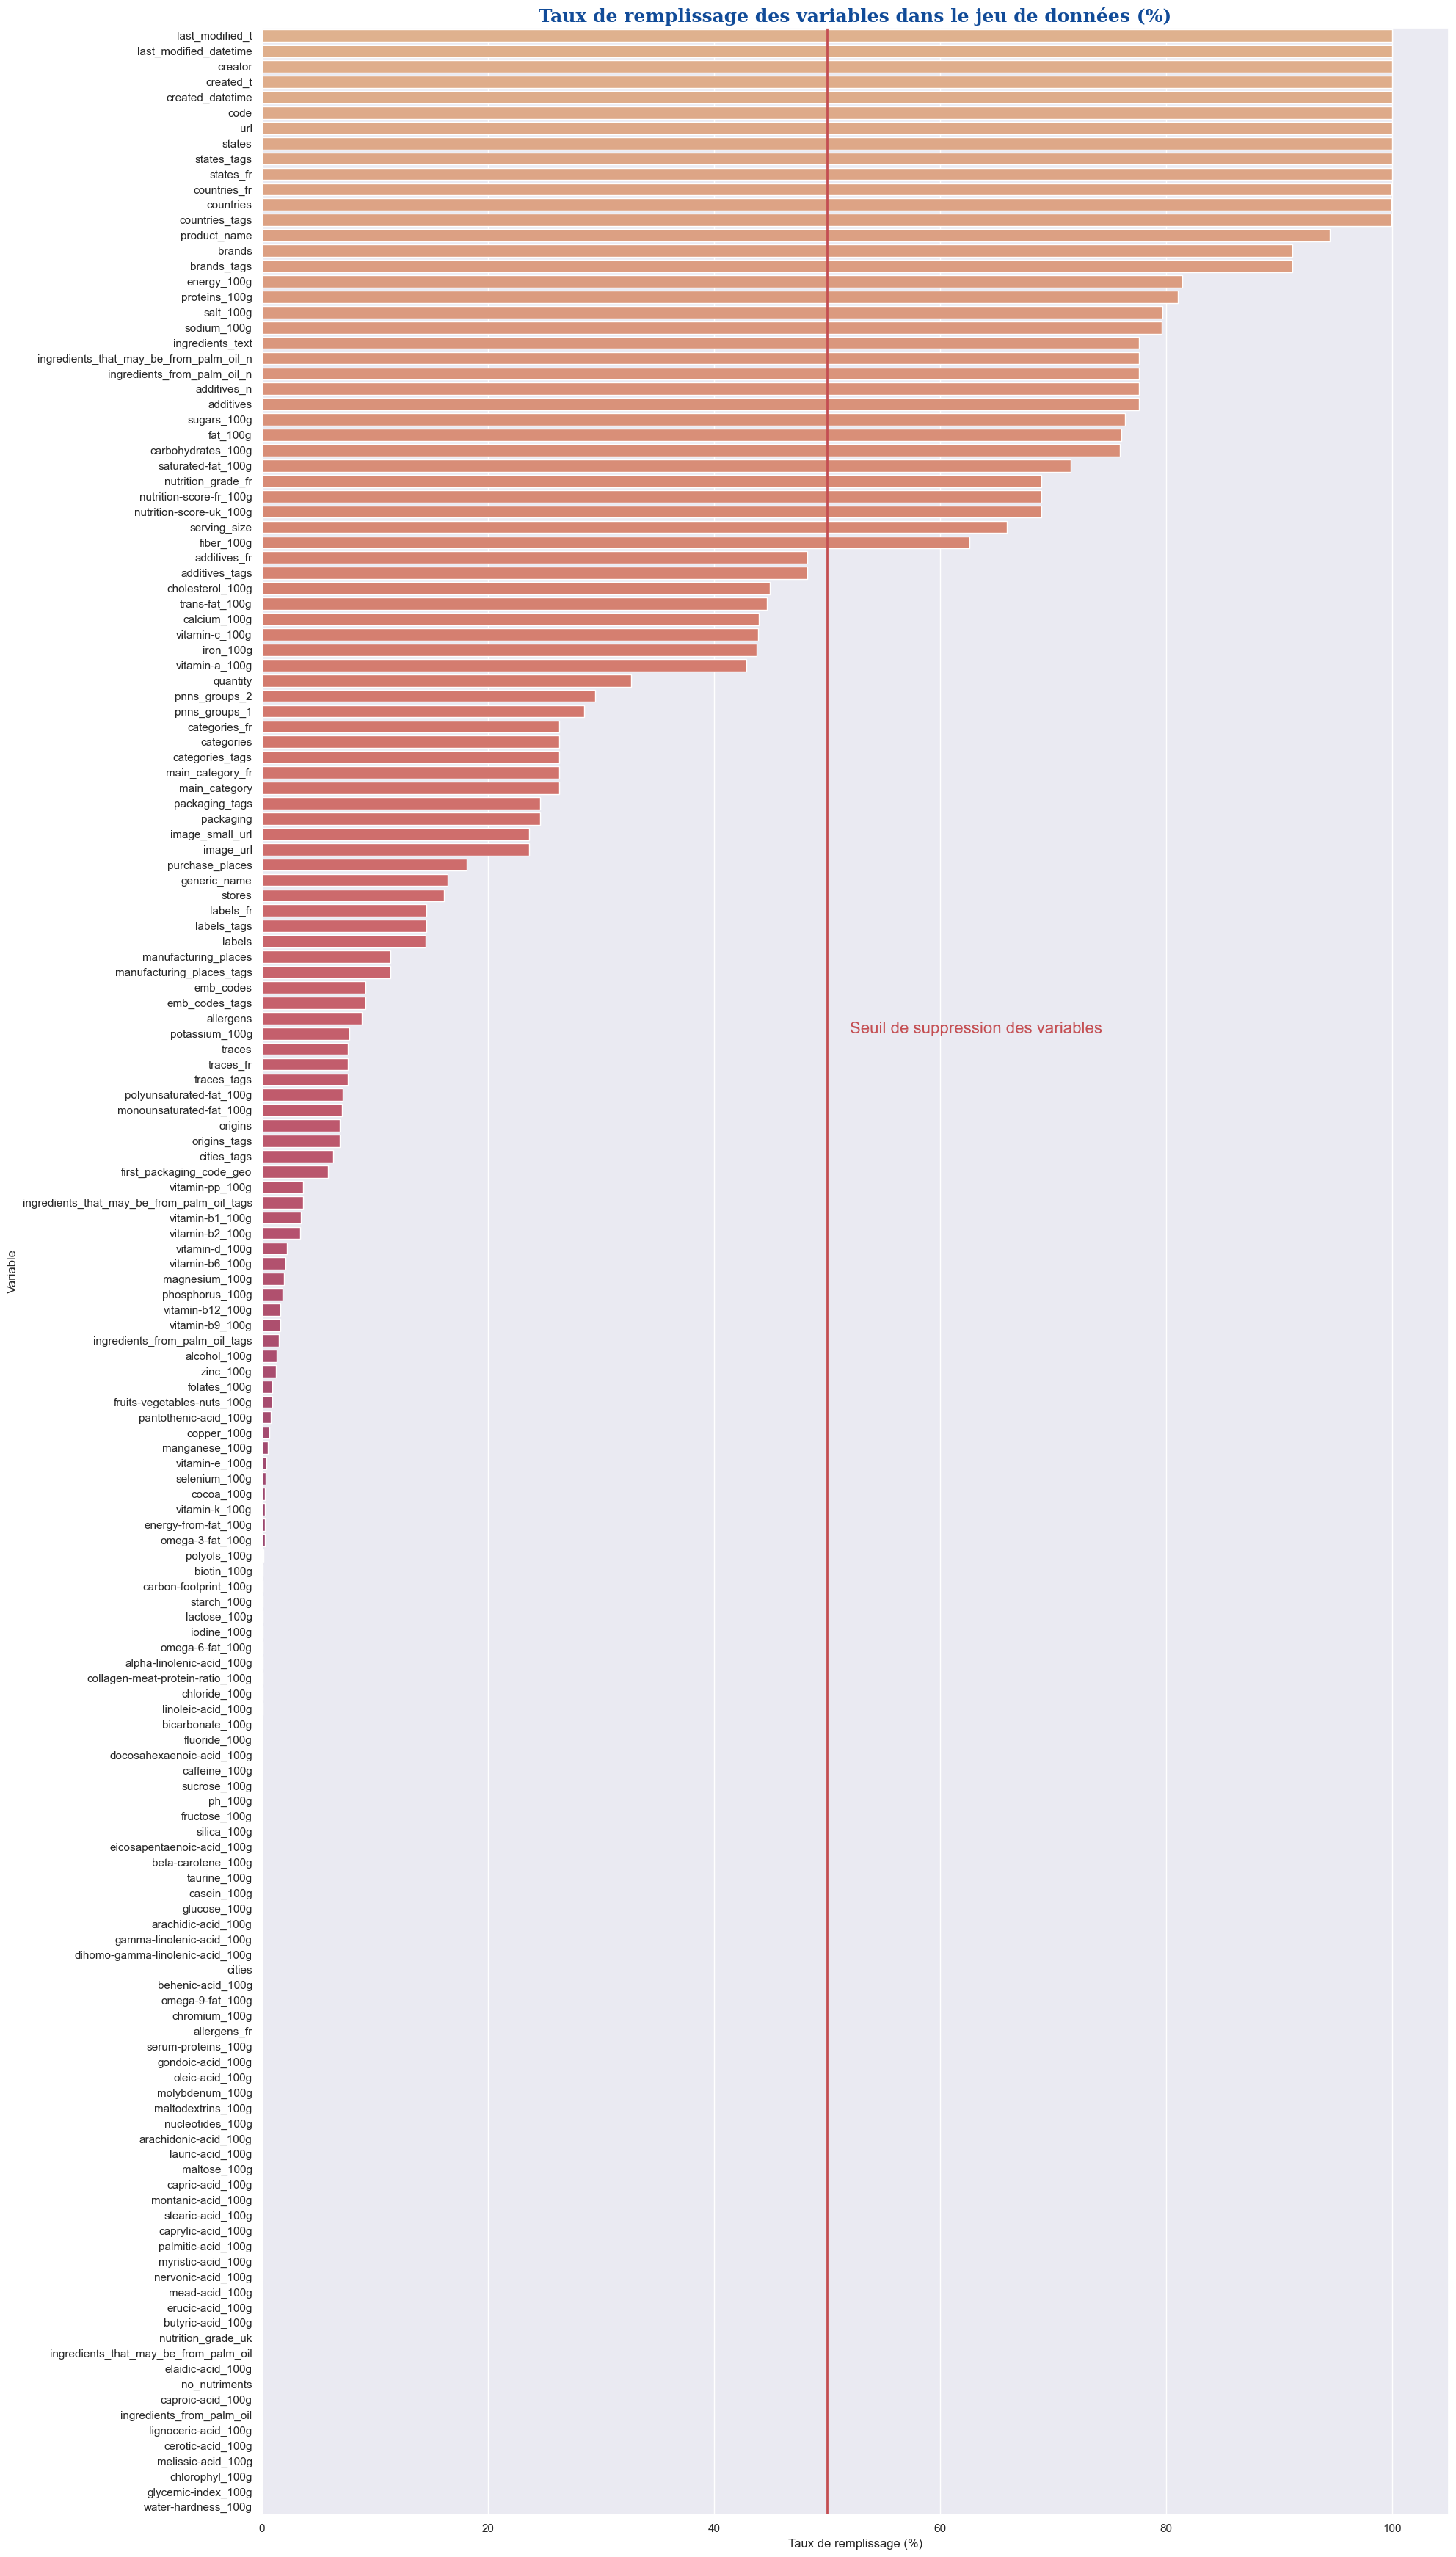

In [64]:
def null_factor(df, tx_threshold=50):
  null_rate = ((df.isnull().sum() / df.shape[0])*100).sort_values(ascending=False).reset_index()
  null_rate.columns = ['Variable','Taux_de_Null']
  high_null_rate = null_rate[null_rate.Taux_de_Null >= tx_threshold]
  return high_null_rate

filling_features = null_factor(df, 0)
filling_features["Taux_de_Null"] = 100-filling_features["Taux_de_Null"]
filling_features = filling_features.sort_values("Taux_de_Null", ascending=False) 

#Seuil de suppression
sup_threshold = 50

fig = plt.figure(figsize=(20, 35))

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }

sns.barplot(x="Taux_de_Null", y="Variable", data=filling_features, palette="flare")
plt.axvline(x=sup_threshold, linewidth=2, color = 'r')
plt.text(sup_threshold+2, 65, 'Seuil de suppression des variables', fontsize = 16, color = 'r')

plt.title("Taux de remplissage des variables dans le jeu de données (%)", fontdict=font_title)
plt.xlabel("Taux de remplissage (%)")
plt.show()

## 1. b) Nettoyage du jeux de données

### filtrage des colonnes / variables par seuil de population

In [65]:
# Permet de savoir toutes les colonnes qui possèdent plus de 50% de valeurs manquantes
data = df.isna().mean() < 0.5
dataColumns = data[data.values].index.to_list()
df_cleaned = df[dataColumns] 
df_cleaned = pd.concat([df[dataColumns] , df['pnns_groups_1']], axis=1)
df_analyse_exploratoire = df_cleaned.copy()
df_cleaned.shape

(320772, 35)

Nous décidons de supprimer les colonnes dont le seuil de remplissage est inférieur à un certain seuil autour de 50%. Nous passons de 162 variables à 34

### Remplacer les valeurs de pnns group 1 à partir de pnns group 2

In [66]:
selected_columns = [ 'product_name', 'brands', 'pnns_groups_1','pnns_groups_2']

# Identifier les lignes contenant des NaN dans les colonnes sélectionnées
nan_rows = df[selected_columns].isna().any(axis=1)

# Afficher les lignes contenant des NaN
df_with_nan = df[nan_rows]

nan_in_pnns_1_not_in_pnns_2 = df[df['pnns_groups_1'].isna() & ~df['pnns_groups_2'].isna()]

# Afficher le résultat
print("Lignes avec NaN dans 'pnns_groups_1' et non NaN dans 'pnns_groups_2':")
print(nan_in_pnns_1_not_in_pnns_2['pnns_groups_2' ].unique())

category_mapping = {
    'Alcoholic beverages': 'beverages',
    'Tripe dishes': 'composite foods'
}

# Compteur pour le nombre de remplacements
replacement_count = 0

# Fonction pour remplacer les valeurs manquantes dans pnns_groups_1 en fonction de pnns_groups_2
def replace_missing_pnns_1(row, category_mapping):
    global replacement_count  # Utilisation de global pour accéder à la variable du niveau supérieur

    if pd.isna(row['pnns_groups_1']):
        if row['pnns_groups_2'] in category_mapping:
            replacement_count += 1
            return category_mapping[row['pnns_groups_2']]
    return row['pnns_groups_1']

# Appliquer la fonction pour remplacer les valeurs manquantes
df['pnns_groups_1'] = df.apply(replace_missing_pnns_1, args=(category_mapping,), axis=1)

# Affichage du nombre de remplacements effectués
print(f"Nombre de valeurs remplacées : {replacement_count}")


Lignes avec NaN dans 'pnns_groups_1' et non NaN dans 'pnns_groups_2':
['Alcoholic beverages' 'Tripe dishes']
Nombre de valeurs remplacées : 2978


### Réduction du nombre de lignes

On uniformise les syntaxes pour pnns group 1 : tiret remplacé par un espace et mise en minuscule

In [67]:
# Suppression des doublons sur code
df_doublons_code = df_cleaned.drop_duplicates(subset ="code", keep = 'last', inplace=False)
print(f"Supression de {df_doublons_code.shape[-1]} lignes car code dupliqué")

# Uniformisation
df_cleaned['pnns_groups_1']=df_cleaned['pnns_groups_1'].str.lower()
df_cleaned['pnns_groups_1']=df_cleaned['pnns_groups_1'].str.replace('-',' ')

df_cleaned=df_cleaned.loc[df_cleaned.pnns_groups_1.notnull()]

print(f"{df_cleaned.shape[0]} lignes au final après supression des doublons sur marques et produits")

Supression de 35 lignes car code dupliqué
91513 lignes au final après supression des doublons sur marques et produits


- suppression de 34 doublons lorsque dans la colonne code, la valeur est dupliquée
- de 320772 à 91513 lignes au final après supression des doublons sur marques et produits

### Suppression des colonnes non pertinentes

In [68]:
def remove_columns(dataframe) :
    df_colonnes = dataframe.columns.tolist()
    columns_to_delete = ['url','created_t','countries_fr','countries_tags', 'last_modified_datetime', 'created_datetime', 
                         'brands_tags',  'serving_size',  'states','states_fr','nutrition-score-uk_100g','creator',
                         'states_tags','ingredients_text','last_modified_t', 'additives_n', 'additives', 'countries',
                         'ingredients_that_may_be_from_palm_oil_n']
    for column in columns_to_delete:
        # Supprime colonne
        df_colonnes.remove(column)
 
    return dataframe[df_colonnes]

df_wo_col = remove_columns(df_cleaned)

### Remplacer les valeurs aberrantes

In [69]:
def valeur_aberrante(df, list_colonne):
    for colonne in list_colonne:
        # Définition des bornes minimale et maximale pour les valeurs aberrantes
        valeur_minimale = 0
        valeur_maximale = 100

        # Création d'un masque pour identifier les valeurs aberrantes 
        masque_aberrant = (df[colonne]  < valeur_minimale) | (df[colonne] > valeur_maximale)

        # Remplacement des valeurs aberrantes par np.nan dans le DataFrame
        df.loc[masque_aberrant, colonne] = np.nan  
        
    return df

g_per_100g_features = ['proteins_100g','fat_100g','carbohydrates_100g','sugars_100g','salt_100g',
                       'sodium_100g','saturated-fat_100g','fiber_100g']

df_100_g = valeur_aberrante(df_wo_col,g_per_100g_features)

Suppresion de lignes aux données aberrantes:
L'energie pour 100g ne peut etre superieur à 3700kj
Les valeurs nutritionnelles ne peuvent être négatives (sauf pour le nutriscore qui peut aller à -15)
Les valeurs nutritionnelles ne peuvent depasser les 100g
100gr de sel doit représenter 38.8g de sodium
les graisses saturées doivent etre inferieures en quantité aux graisses
le nutriscore doit etre compris entre -15 et +40

In [70]:
df_cleaned = df_wo_col.copy()
df_new = df_100_g[~((df_100_g['saturated-fat_100g'] > df_100_g['fat_100g']) 
                                | (df_100_g['sodium_100g'] > df_100_g['salt_100g']))]

df_cleaned.loc[:, g_per_100g_features] = df_new.loc[:, g_per_100g_features]

# on supprime les valeurs ou le saturated fat > fat
df_cleaned = df_cleaned.loc[((df_100_g['saturated-fat_100g']<df_100_g.fat_100g) | (df_100_g['saturated-fat_100g'].isnull()) | (df_100_g.fat_100g.isnull()))]
df_cleaned = df_cleaned.loc[df_cleaned['energy_100g'] <= 3700]

# on supprime les lignes dont le nutriscore est inferieur à -15 ou > 40 
df_cleaned=df_cleaned.loc[(df_cleaned['nutrition-score-fr_100g']>=-15) & (df_cleaned['nutrition-score-fr_100g']<=40)]

In [71]:
df_cleaned.describe()

ingredients_from_palm_oil_n  energy_100g  fat_100g  saturated-fat_100g  \
count                    47,815.00    55,201.00 51,894.00           55,201.00   
mean                          0.07     1,177.32     14.98                5.87   
std                           0.26       765.48     17.04                8.34   
min                           0.00         0.00      0.00                0.00   
25%                           0.00       485.00      2.30                0.50   
50%                           0.00     1,103.00      9.00                2.40   
75%                           0.00     1,738.00     23.20                8.50   
max                           2.00     3,700.00    100.00               99.90   

       carbohydrates_100g  sugars_100g  fiber_100g  proteins_100g  salt_100g  \
count           51,859.00    55,197.00   35,883.00      55,201.00  55,197.00   
mean                28.27        12.38        2.96           8.21       1.01   
std                 26.72        17.37        4.09           7.48       2.56   
min                  0.00         0.00        0.00           0.00       0.00   
25%                  4.30         1.00        0.50           3.00       0.10   
50%                 16.00         3.70        1.90           6.40       0.63   
75%                 53.70        16.80        3.80          11.00       1.30   
max                100.00       100.00      100.00         100.00     100.00   

       sodium_100g  nutrition-score-fr_100g  
count    55,200.00                55,201.00  
mean          0.40                     8.69  
std           1.12                     9.26  
min           0.00                   -15.00  
25%           0.04                     1.00  
50%           0.25                     9.00  
75%           0.51                    16.00  
max          83.00                    40.00

## 1. c) Imputation des données manquantes

In [72]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

def best_imputation_method(df, column_name):
    # Copy the DataFrame to avoid modifying the original
    data = df[column_name].dropna().copy()

    # Store the results of each method
    results = {}

    imputation_strategies = {
        'mean': SimpleImputer(missing_values=np.nan, strategy='mean'),
        'median': SimpleImputer(missing_values=np.nan, strategy='median'),
        'mode': SimpleImputer(missing_values=np.nan, strategy='constant'),
        'knn': KNNImputer(missing_values=np.nan)

    }

    for strategy_name, strategy in imputation_strategies.items():
            
        n_samples = data.shape[0]
        missing_rate = 0.3
        n_missing_samples = int(np.floor(n_samples * missing_rate))

        # choix des lignes à valeurs manquantes
        present = np.zeros(n_samples - n_missing_samples, dtype=bool)
        missing = np.ones(n_missing_samples, dtype=bool)
        missing_samples = np.concatenate((present, missing))
        np.random.shuffle(missing_samples)

        data_missing = data.copy()
        data_missing[missing_samples] = np.nan

        if strategy_name != 'knn':
            # Impute using mean, median, or mode
            imputed_data = strategy.fit_transform(data_missing.values.reshape(-1, 1))

        else:       
            imputed_data = strategy.fit_transform(data_missing.values.reshape(-1, 1))

    # Calculate R-squared with imputed values
        rmse = np.sqrt(mean_squared_error(data[missing_samples],imputed_data[missing_samples]))
        results[strategy_name] = rmse
        # print(strategy_name, rmse)
        
    # Find the best imputation method based on RMSE
    best_strategy = min(results, key=results.get)
    # Return the best imputed data and the RMSE score of the best method

    return best_strategy

columns_imput = ['proteins_100g','carbohydrates_100g','fiber_100g','saturated-fat_100g','sodium_100g','salt_100g','sugars_100g', 'fat_100g','energy_100g', 'ingredients_from_palm_oil_n', 'nutrition-score-fr_100g']
imputation_methods = {}
for column in columns_imput:
    #if df_cleaned[column].isna().any():
        imputation_methods[column] = best_imputation_method(df_new, column)
print("Best method imputation")
print(imputation_methods)

Best method imputation
{'proteins_100g': 'median', 'carbohydrates_100g': 'mean', 'fiber_100g': 'median', 'saturated-fat_100g': 'knn', 'sodium_100g': 'mean', 'salt_100g': 'mean', 'sugars_100g': 'mean', 'fat_100g': 'mean', 'energy_100g': 'median', 'ingredients_from_palm_oil_n': 'mean', 'nutrition-score-fr_100g': 'median'}


In [73]:
df_imput= df_cleaned.copy()
knn_features = ['proteins_100g','carbohydrates_100g','fiber_100g']
# On entraine le modèle d'imputation sur un échantillon de données
sample_datas = df_imput[knn_features].sample(frac=0.25, random_state=1)
imputer = KNNImputer(n_neighbors=5, missing_values=np.nan)
imputer.fit(sample_datas)

datas_imputed = imputer.transform(df_imput[knn_features])
df_datas_imputed = pd.DataFrame(datas_imputed, columns=knn_features)
for col_knn in ['proteins_100g','carbohydrates_100g','fiber_100g']:
    df_imput.loc[:,col_knn] = df_datas_imputed[col_knn].values

In [74]:
# On complète les variables restantes avec la moyenne 
for col in ['saturated-fat_100g','sodium_100g','salt_100g','sugars_100g', 'fat_100g','energy_100g']:
     df_imput.loc[:,col] = df_imput[col].transform(lambda x: x.fillna(x.mean()))

In [75]:
for col in  ['ingredients_from_palm_oil_n', 'nutrition-score-fr_100g']:
    df_imput.loc[:,col] = df_imput[col].transform(lambda x: x.fillna(x.median()))

### Analyse exploratoire



Analyse valeur qualitative

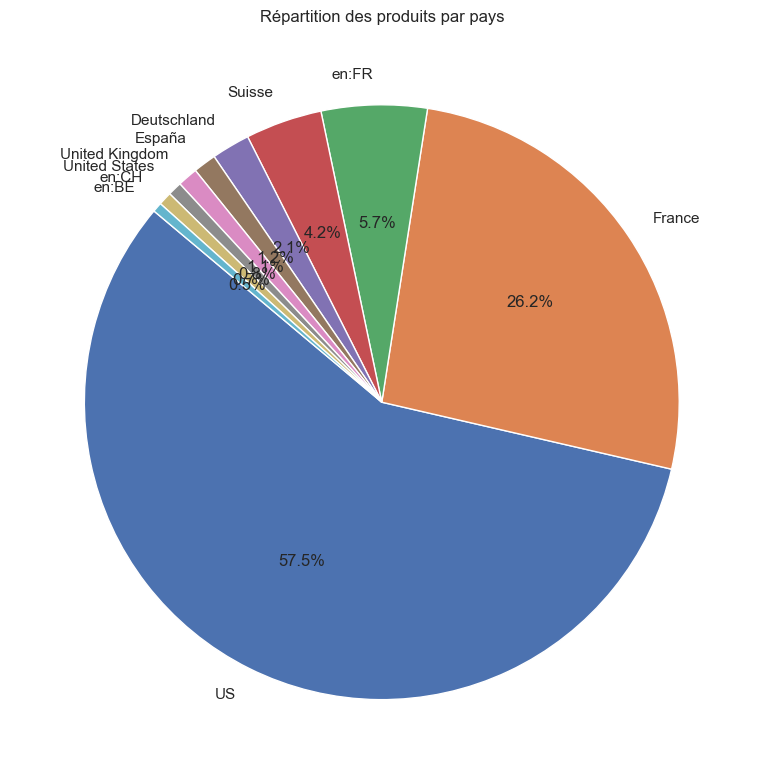

In [76]:
df_country = df_analyse_exploratoire.copy()
df_country = df_country.dropna(subset=['countries'])

# Compter les occurrences de chaque pays
countries_count = df_country['countries'].value_counts()

# Limiter le nombre de pays pour des raisons de lisibilité si nécessaire
top_countries = countries_count.head(10)  # par exemple, les 10 premiers pays

# Créer un diagramme camembert
plt.figure(figsize=(8, 8))
plt.pie(top_countries, labels=top_countries.index, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des produits par pays')
plt.show()

On constate des catégories très désèquilibrées. La plus représentée est "France" (78.4%)

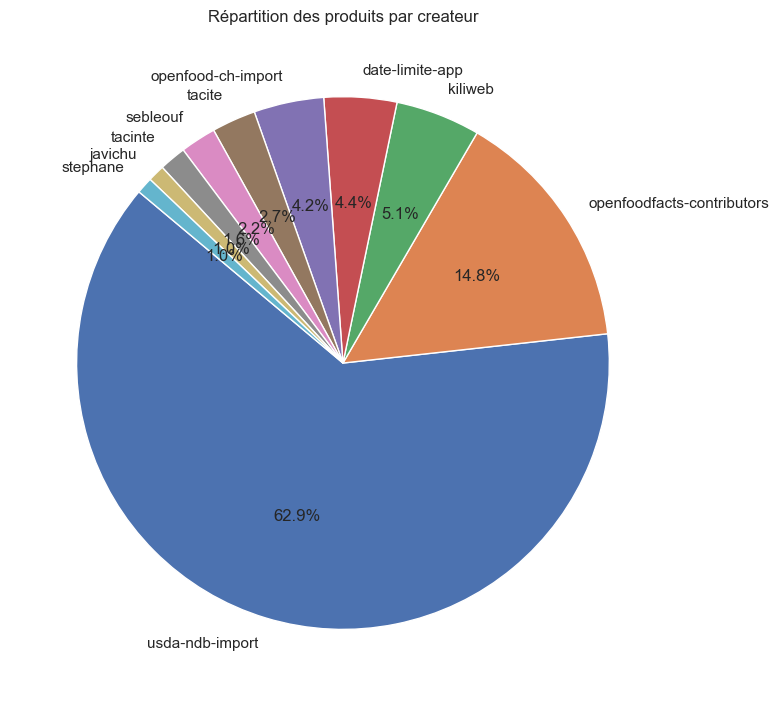

In [77]:
df_creator= df_analyse_exploratoire.copy()
df_creator= df_creator.dropna(subset=['creator'])

creator_count = df_creator['creator'].value_counts()
top_creator = creator_count.head(10)  

plt.figure(figsize=(8, 8))
plt.pie(top_creator, labels=top_creator.index, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des produits par createur')
plt.show()

On constate des catégories très désèquilibrées. La plus représentée est "usda-ndb-import" (62.9%)

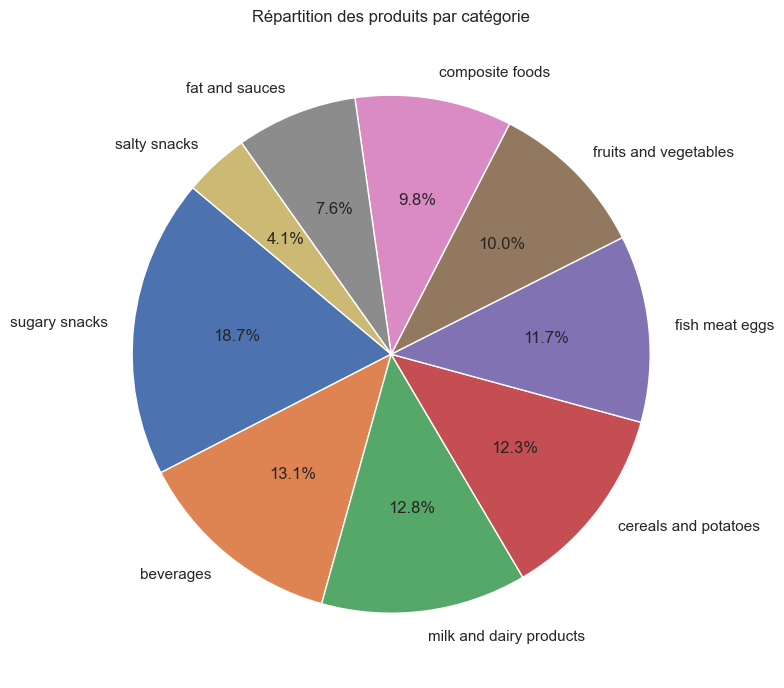

In [78]:
df_pnns_group_1= df_analyse_exploratoire.copy()
df_pnns_group_1['pnns_groups_1']=df_pnns_group_1['pnns_groups_1'].replace('unknown',np.nan)
df_pnns_group_1['pnns_groups_1']=df_pnns_group_1['pnns_groups_1'].str.lower()
df_pnns_group_1['pnns_groups_1']=df_pnns_group_1['pnns_groups_1'].str.replace('-',' ')

df_pnns_group_1 = df_pnns_group_1.dropna(subset=['pnns_groups_1'])
pnns_group_1_count = df_pnns_group_1['pnns_groups_1'].value_counts()
top_pnns_group_1 = pnns_group_1_count.head(10)  

# Créer un diagramme camembert
plt.figure(figsize=(8, 8))
plt.pie(top_pnns_group_1, labels=top_pnns_group_1.index, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des produits par catégorie')
plt.show()

On constate des catégories légèrement désèquilibrées. La plus représentée est "sugary-snack" (18.7%) et la moins representée est salty snacks (4.1%)

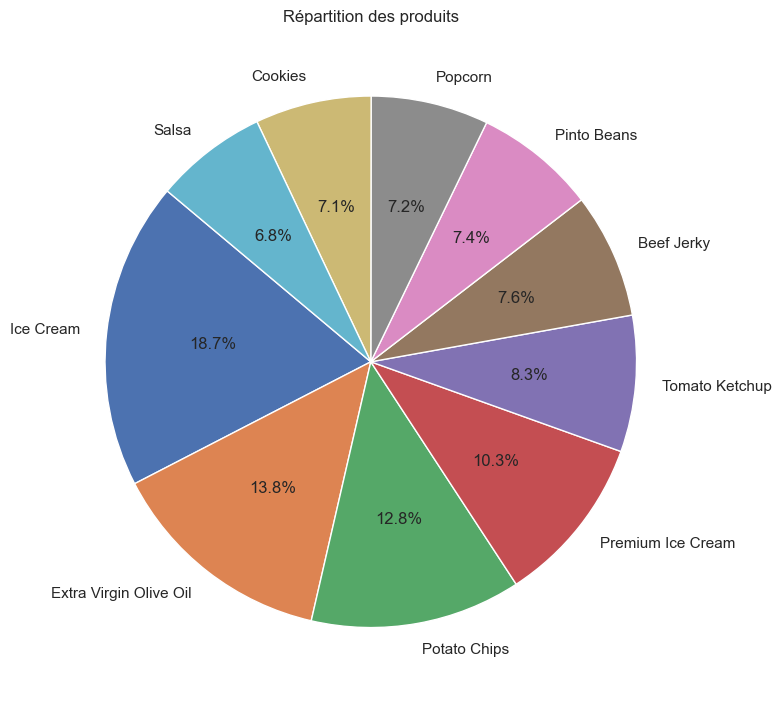

In [79]:
df_product =  df_analyse_exploratoire.copy()
df_product= df_product.dropna(subset=['product_name'])

# Compter les occurrences de chaque pays
product_count = df_product['product_name'].value_counts()

# Limiter le nombre de pays pour des raisons de lisibilité si nécessaire
top_product = product_count.head(10)  # par exemple, les 10 premiers pays

# Créer un diagramme camembert
plt.figure(figsize=(8, 8))
plt.pie(top_product, labels=top_product.index, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des produits')
plt.show()

Un dendrogramme est un arbre de regroupement (ou arbre hiérarchique) qui indique comment les colonnes du DataFrame sont similaires ou dissemblables en termes de données manquantes.

<Axes: >

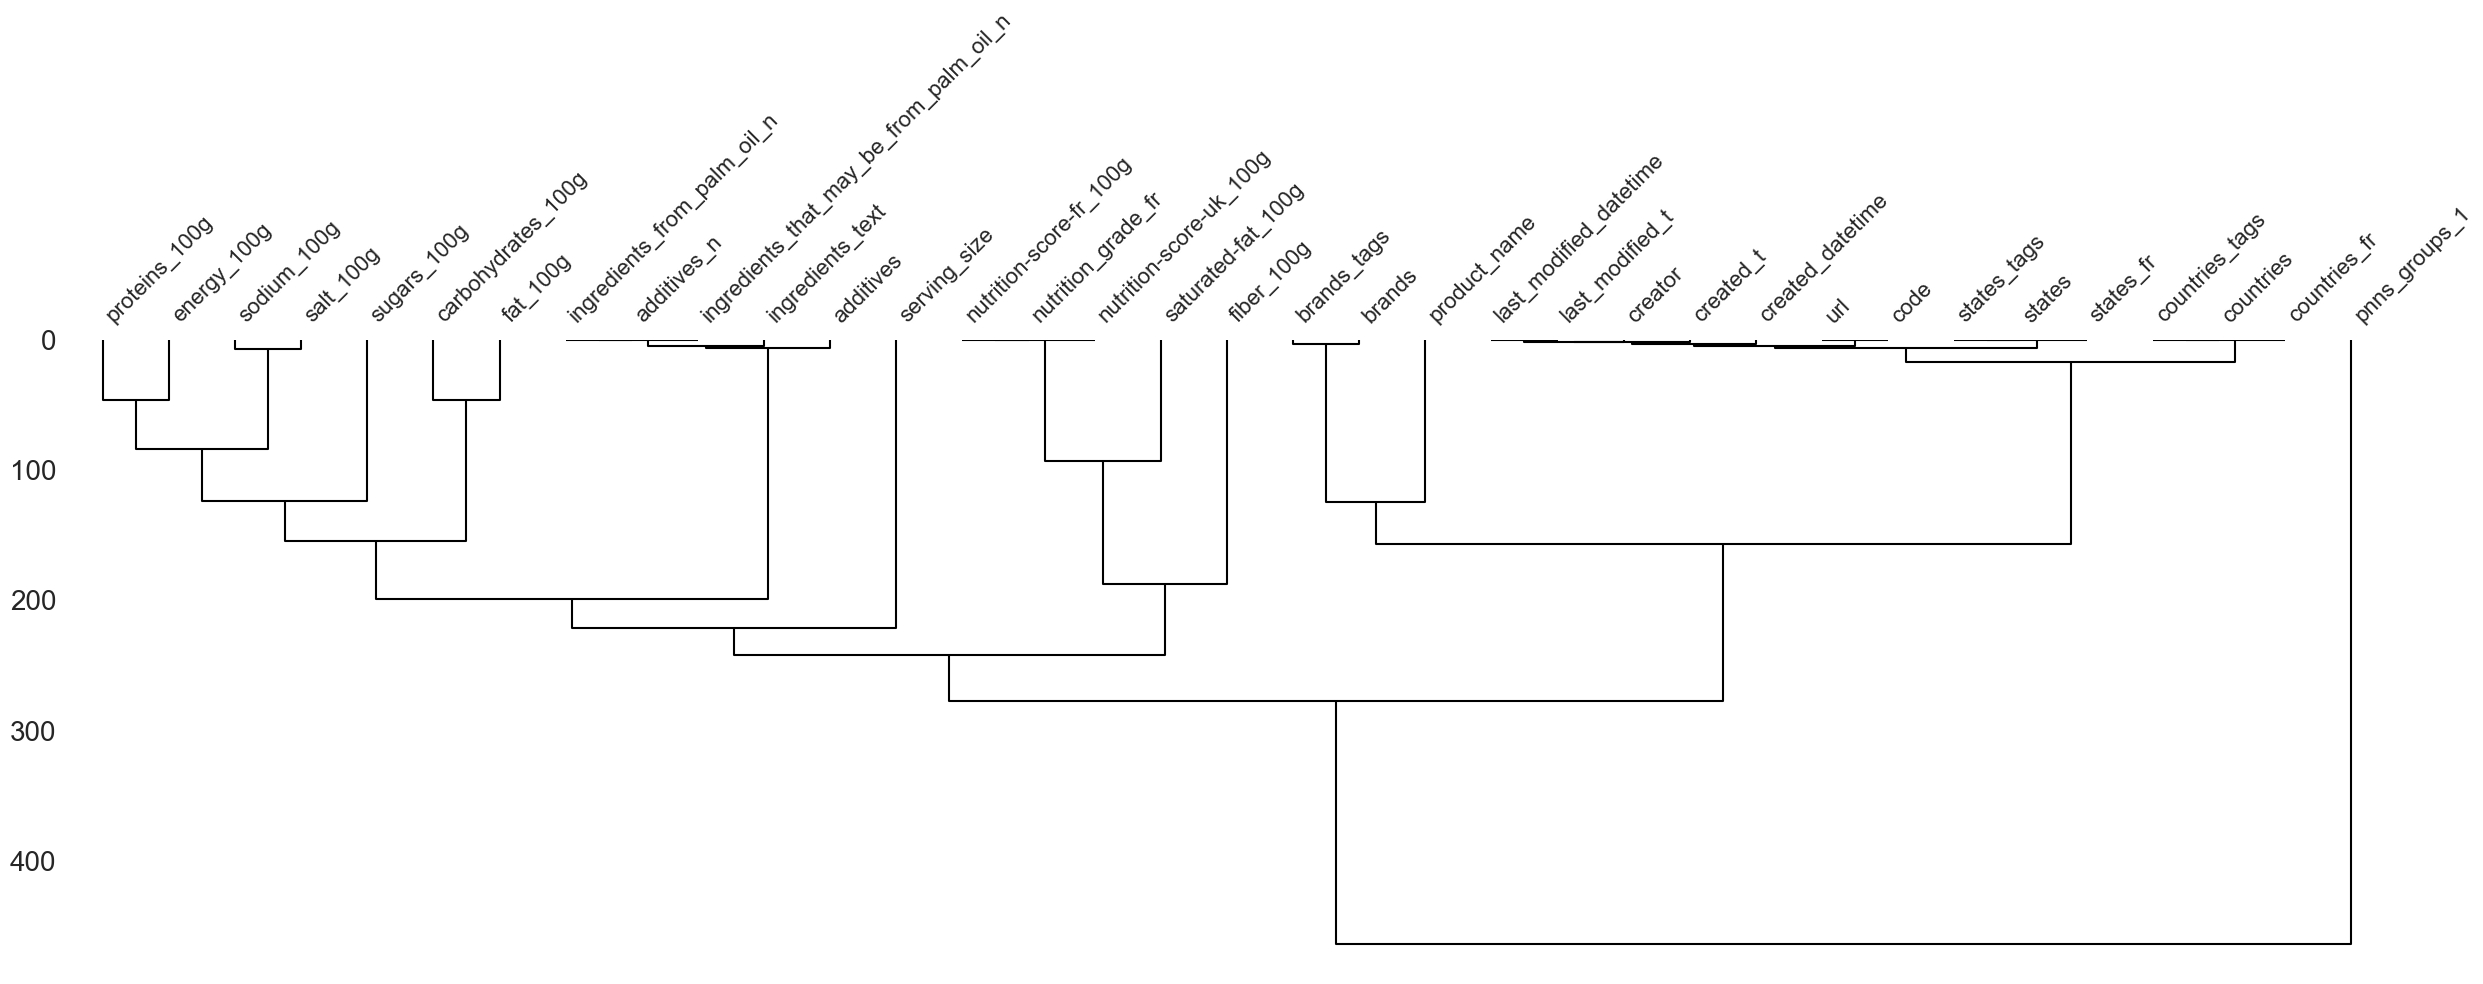

In [80]:
msno.dendrogram(df_analyse_exploratoire)

Cette matrice permet de visualiser les valeurs manquantes dans ces données :

<Axes: >

/Users/atfehranacz53_cb/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/atfehranacz53_cb/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


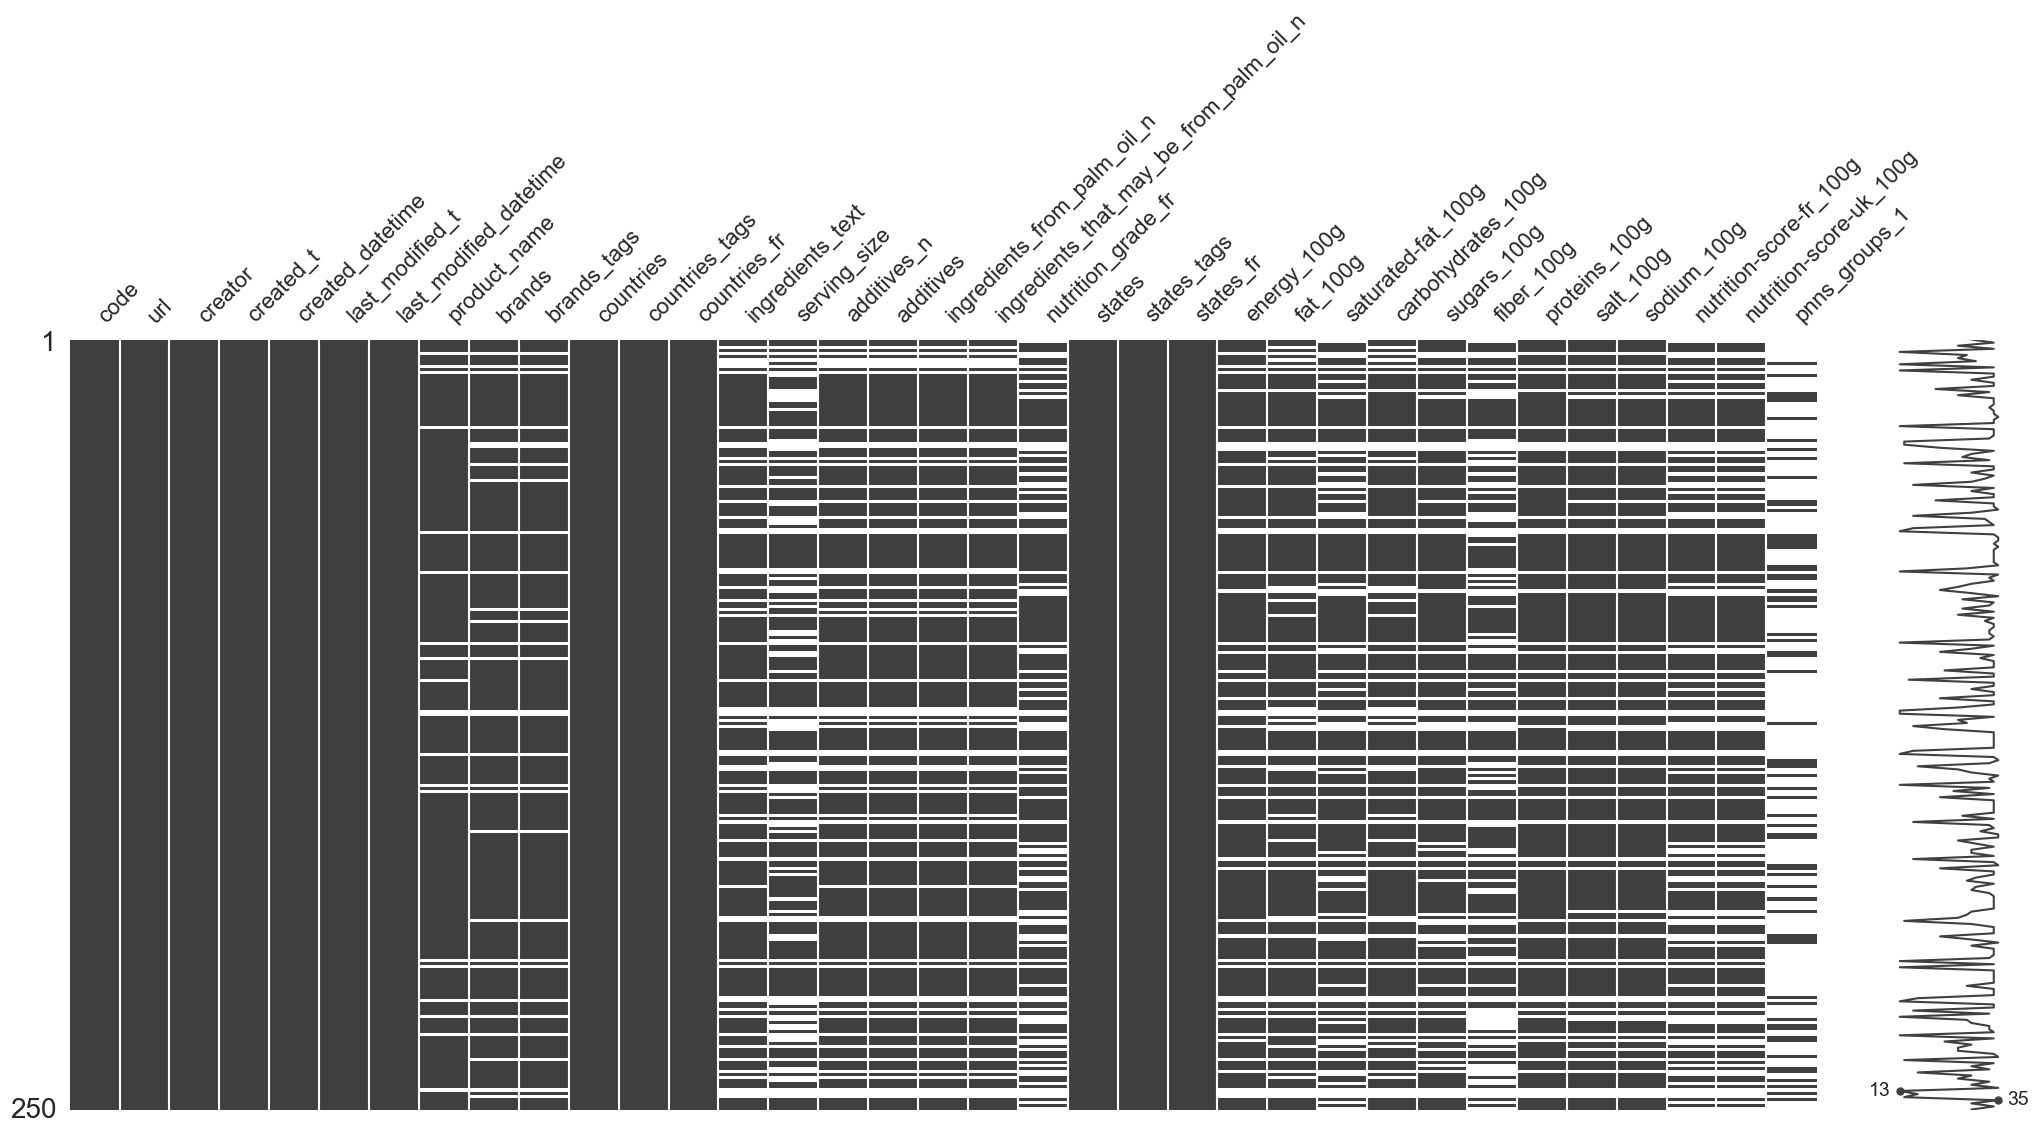

In [81]:
msno.matrix(df_analyse_exploratoire.sample(250))

Le tableau suivant montre visuellement la proportion de données manquantes dans un échantillon de 1000 données 

<Axes: >

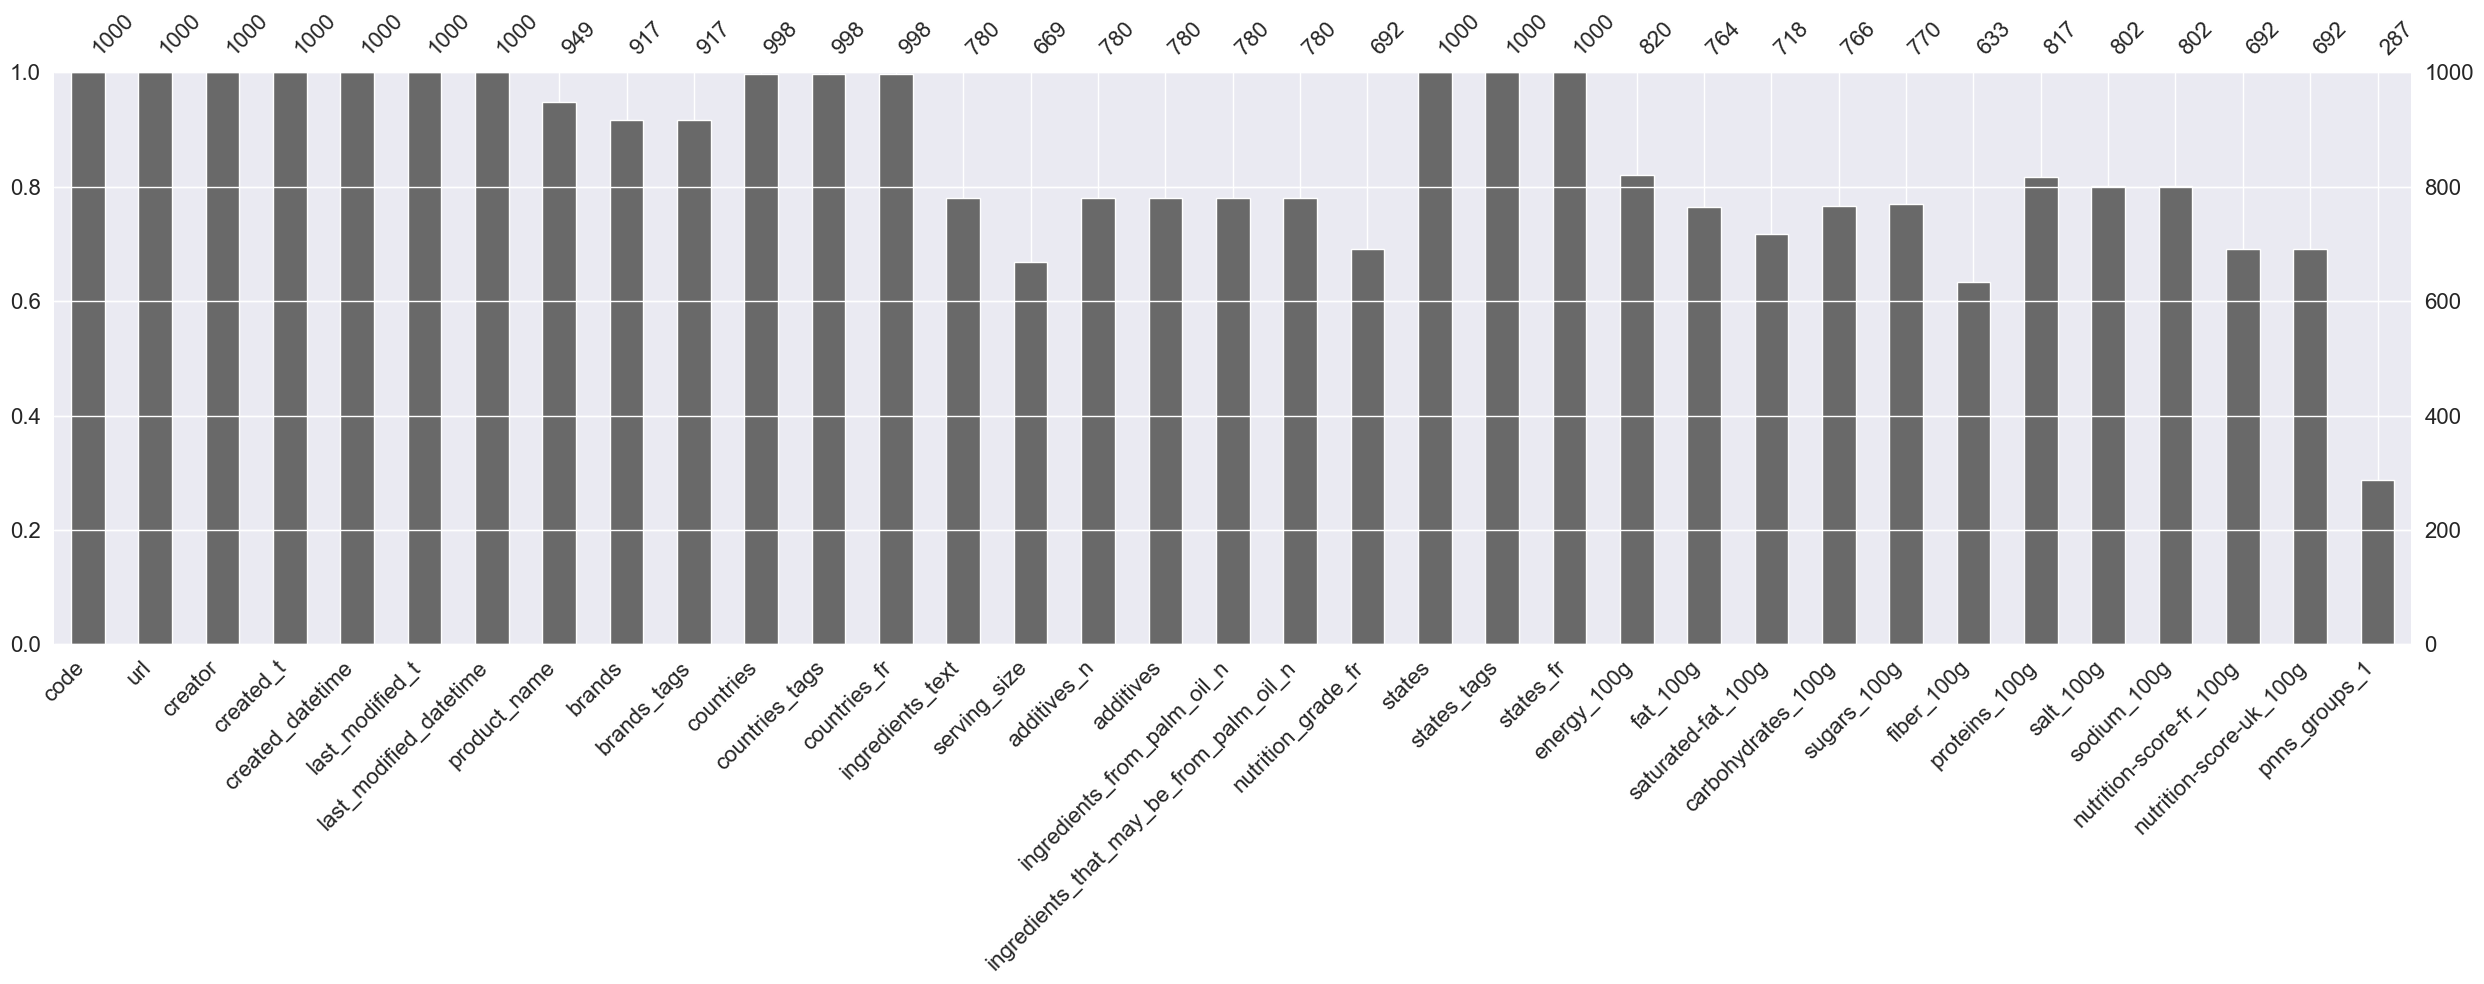

In [82]:
msno.bar(df_analyse_exploratoire.sample(1000))

L'outil suivant permet la visualisation afin d'explorer les corrélations entre les données manquantes dans un ensemble de données.

<Axes: >

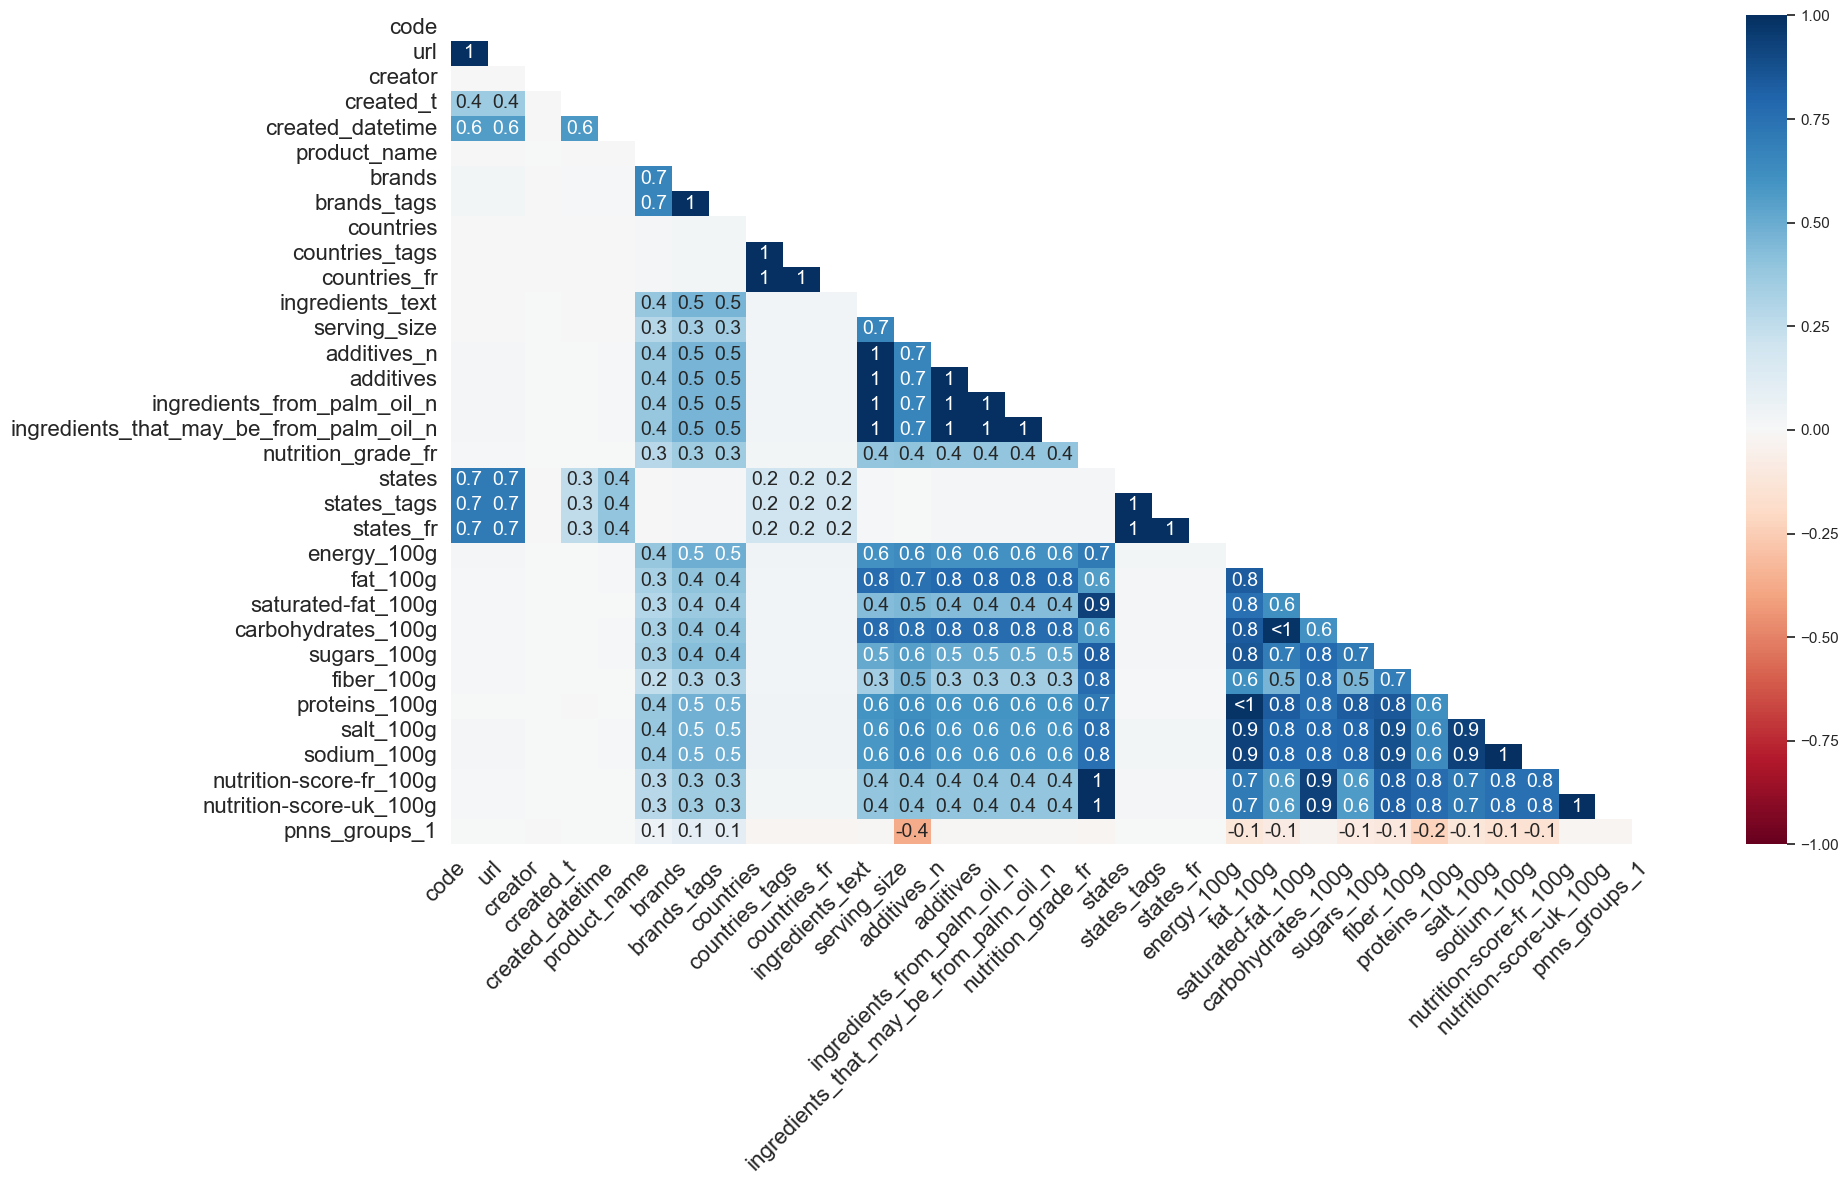

In [83]:
msno.heatmap(df_analyse_exploratoire)

## 2. a) Analyse univariée

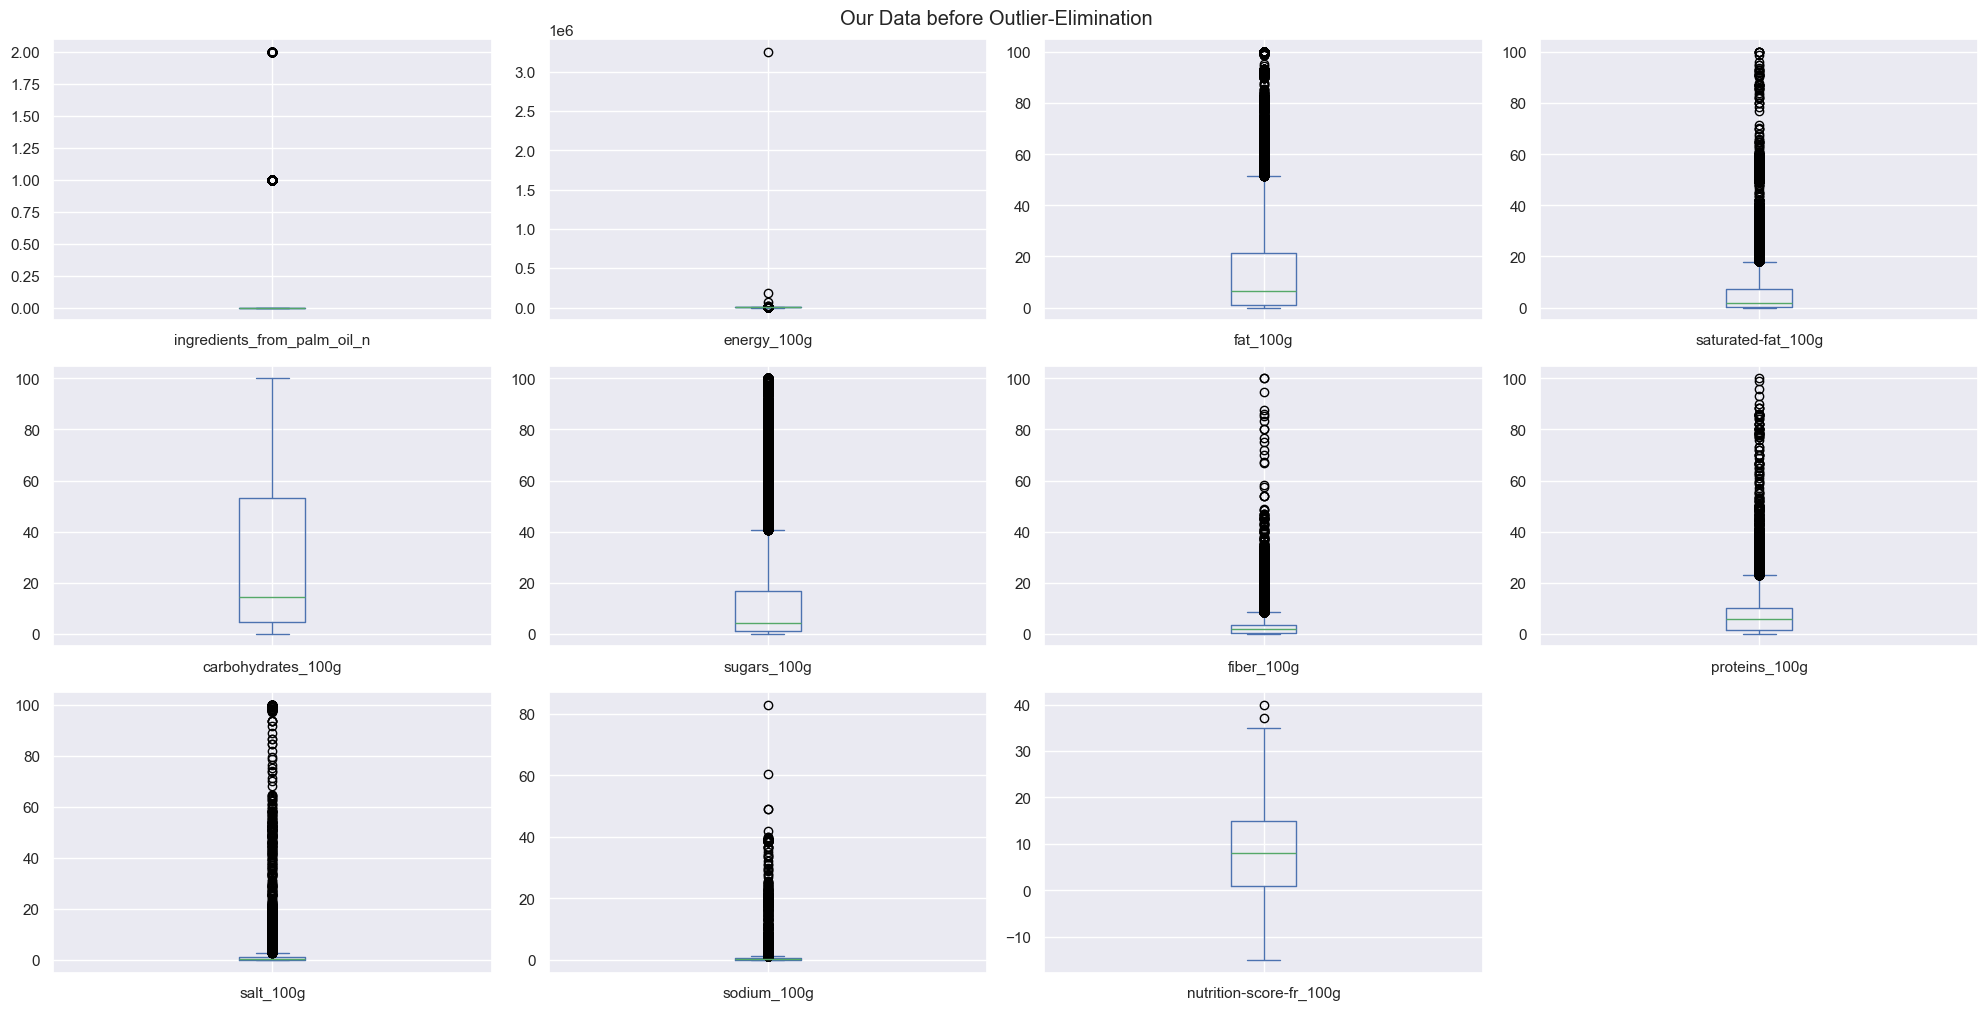

In [84]:
# Creation boite à moustache des variables quantitatives
df_new.select_dtypes(include=float).plot(kind='box', subplots=True, title='Our Data before Outlier-Elimination', figsize=(20,20), layout=(6,4))
plt.show()

Les valeurs sont concentrées dans l'interval inter-quartile en fonction des valeurs nutritionnelles. La boîte à moustache montre de nombreuses observations qui ont des valeurs atypiques située au delà de la borne supérieur de 1,5 interquartile. 

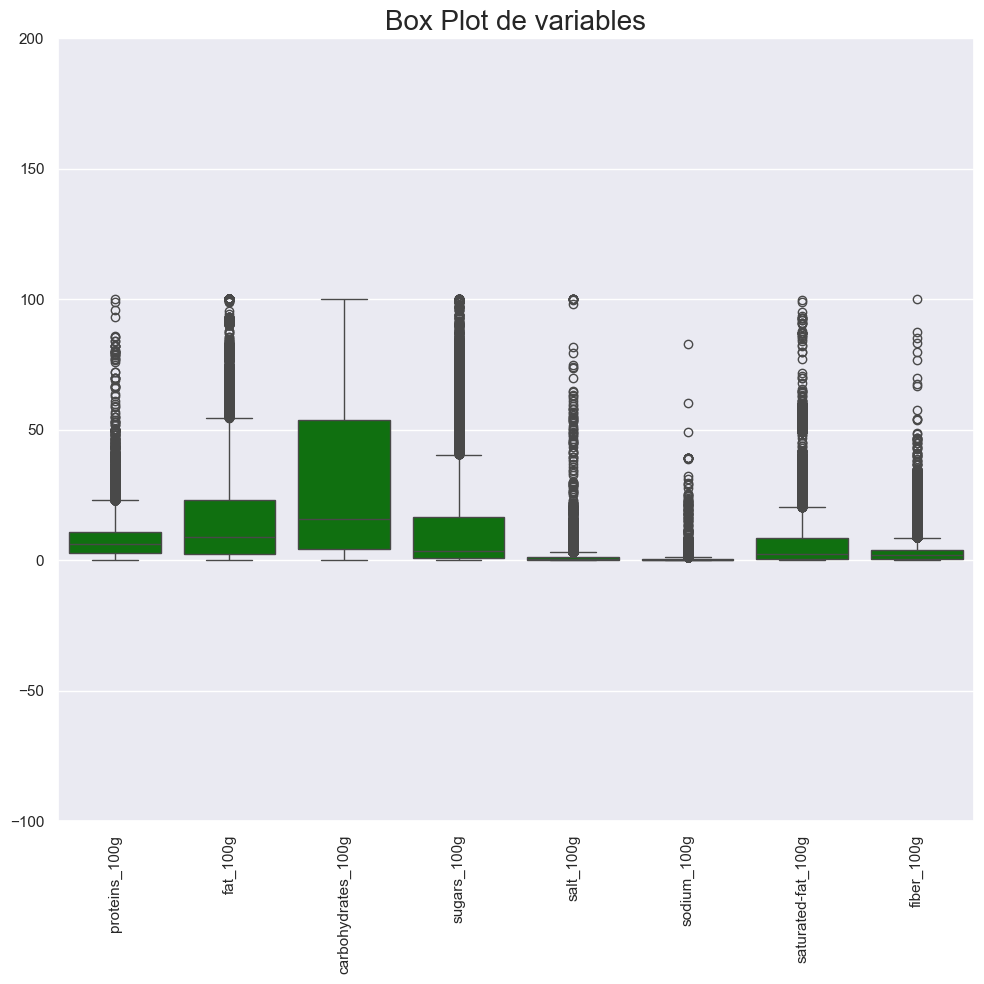

In [85]:
degrees = 90
# Creation boite à moustache des variables quantitatives
plt.figure(figsize=(10,10)) 
ax=plt.axes()
plt.xticks(rotation = degrees)
ax.set_ylim([-1e2,2e2])
sns.boxplot(data=df_cleaned[g_per_100g_features],color='green').set_title("Box Plot de variables",fontsize=20) 
plt.show()

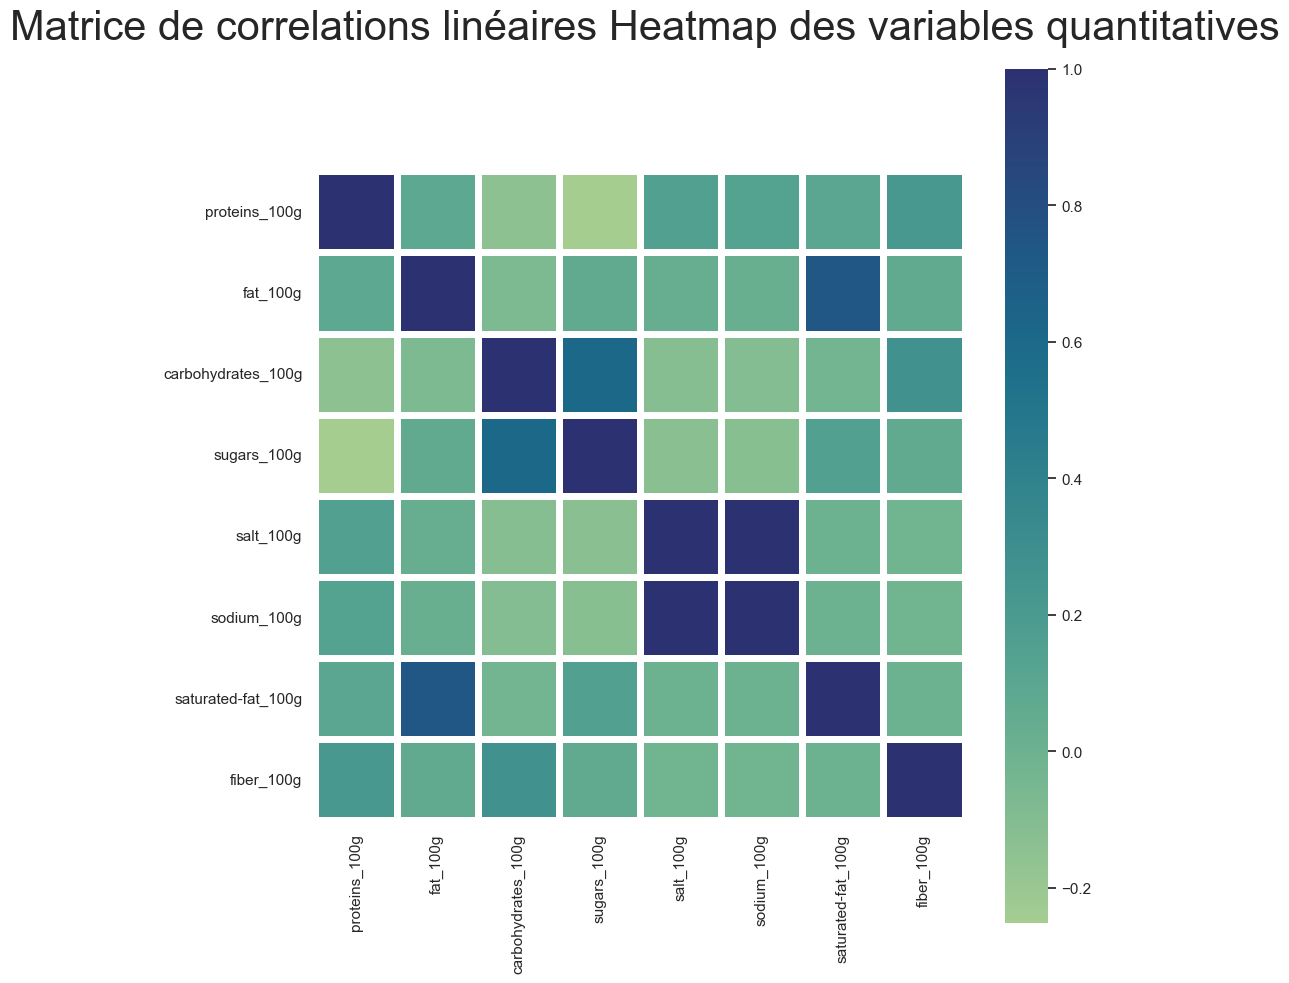

In [86]:
# Creation Heatmap des variables quantitatives
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(df_cleaned[g_per_100g_features].corr(),annot = False,square=True,linewidth = 5, cmap="crest")
plt.suptitle('Matrice de correlations linéaires Heatmap des variables quantitatives',fontsize = 30)
plt.show()

## 2. b) Analyse bivariée

Chaque grade correspond à un intervalle de nutriscore
les scores les moins élevés correspondent aux meilleurs grades alors que les scores les plus élevées correspondent aux moins bons grades

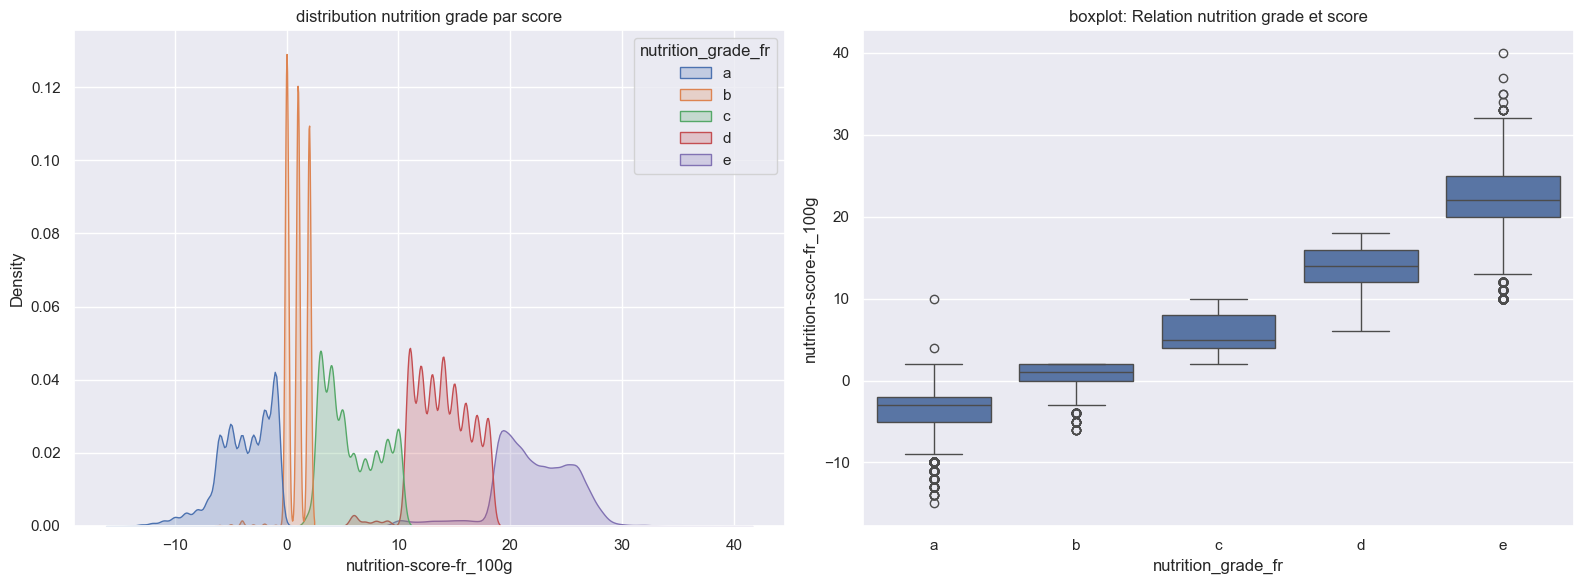

statistique descriptive des grades/scores


nutrition-score-fr_100g                                \
                                     count  mean  std    min   25%   50%   
nutrition_grade_fr                                                         
a                                 9,943.00 -3.77 2.41 -15.00 -5.00 -3.00   
b                                 7,837.00  0.90 0.94  -6.00  0.00  1.00   
c                                11,766.00  5.83 2.47   2.00  4.00  5.00   
d                                15,307.00 13.97 2.45   6.00 12.00 14.00   
e                                10,348.00 22.01 3.56  10.00 20.00 22.00   

                                
                     75%   max  
nutrition_grade_fr              
a                  -2.00 10.00  
b                   2.00  2.00  
c                   8.00 10.00  
d                  16.00 18.00  
e                  25.00 40.00

In [87]:
temp=df_imput.loc[:,['nutrition-score-fr_100g','nutrition_grade_fr']].sort_values(by=['nutrition_grade_fr'])

plt.rcParams["figure.figsize"] = [16, 6]
plt.rcParams["figure.autolayout"] = True

f, axes = plt.subplots(1, 2)

# Plot 1 : Kernel Density Estimate (KDE) avec couleurs distinguant les grades nutritionnels
sns.kdeplot(x='nutrition-score-fr_100g', hue='nutrition_grade_fr', fill=True,data=temp,ax=axes[0])

# Plot 2 : Boxplot montrant la relation entre les grades nutritionnels et les scores
sns.boxplot(x='nutrition_grade_fr', y='nutrition-score-fr_100g', data=temp,ax=axes[1])
axes[0].title.set_text('distribution nutrition grade par score')
axes[1].title.set_text('boxplot: Relation nutrition grade et score')
plt.show()

# Statistique descriptive des grades et scores
print('statistique descriptive des grades/scores')
pd.options.display.float_format = '{:,.2f}'.format
display(df_imput.loc[:,['nutrition-score-fr_100g','nutrition_grade_fr']].groupby('nutrition_grade_fr').describe())

Sans supprise la distribution de la variable nutrition grade évolue linéairement avec les modalités de la variable nutriscore.

nutrition_grade_fr          a     b     c     d     e
pnns_groups_1                                        
beverages                 196   421   711   411   929
cereals and potatoes     3390  1026  1339   834   111
composite foods          1301  1749  1577   867    69
fat and sauces             78   198   889  1485   686
fish meat eggs            527   719  1431  1572  1060
fruits and vegetables    2320   636   428    45     3
milk and dairy products   501  1322  1656  2874   264
salty snacks               54    79   664  1180   363
sugary snacks              57   201   727  3120  4967


<Figure size 1000x600 with 0 Axes>

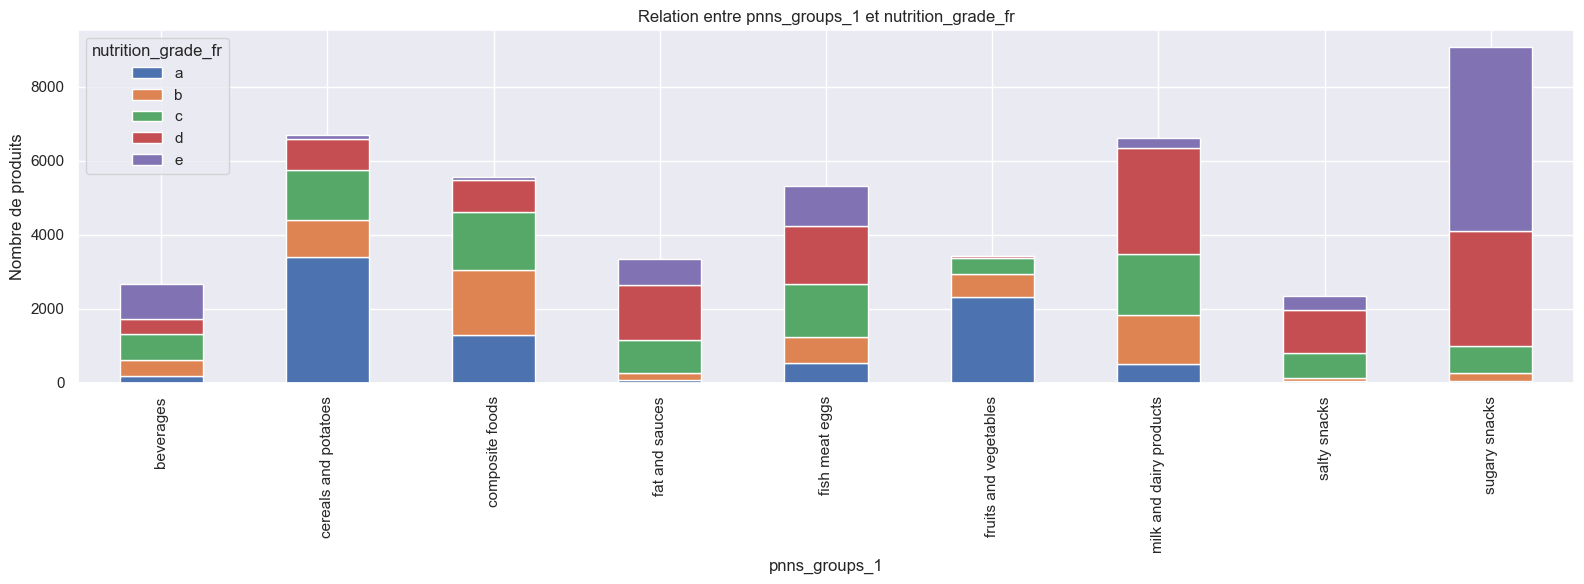

In [88]:
df = df_imput.copy() 
df['pnns_groups_1']=df['pnns_groups_1'].replace('unknown',np.nan)
df=df.loc[df.pnns_groups_1.notnull()]
cross_table = pd.crosstab(df['pnns_groups_1'], df['nutrition_grade_fr'])
print(cross_table)

# Diagramme en barres
plt.figure(figsize=(10, 6))
df.groupby(['pnns_groups_1', 'nutrition_grade_fr']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Relation entre pnns_groups_1 et nutrition_grade_fr')
plt.xlabel('pnns_groups_1')
plt.ylabel('Nombre de produits')
plt.show()

On constate une relation entre les catégories de pnns group 1 et le nutrition grade en effet pour cereal ans potatoes, fruits and vegetables le grade e est bien representé a car ceux sont des aliments sains tandis que sugary snacks est bien representé par le grade e qui est bien sûr moins soins

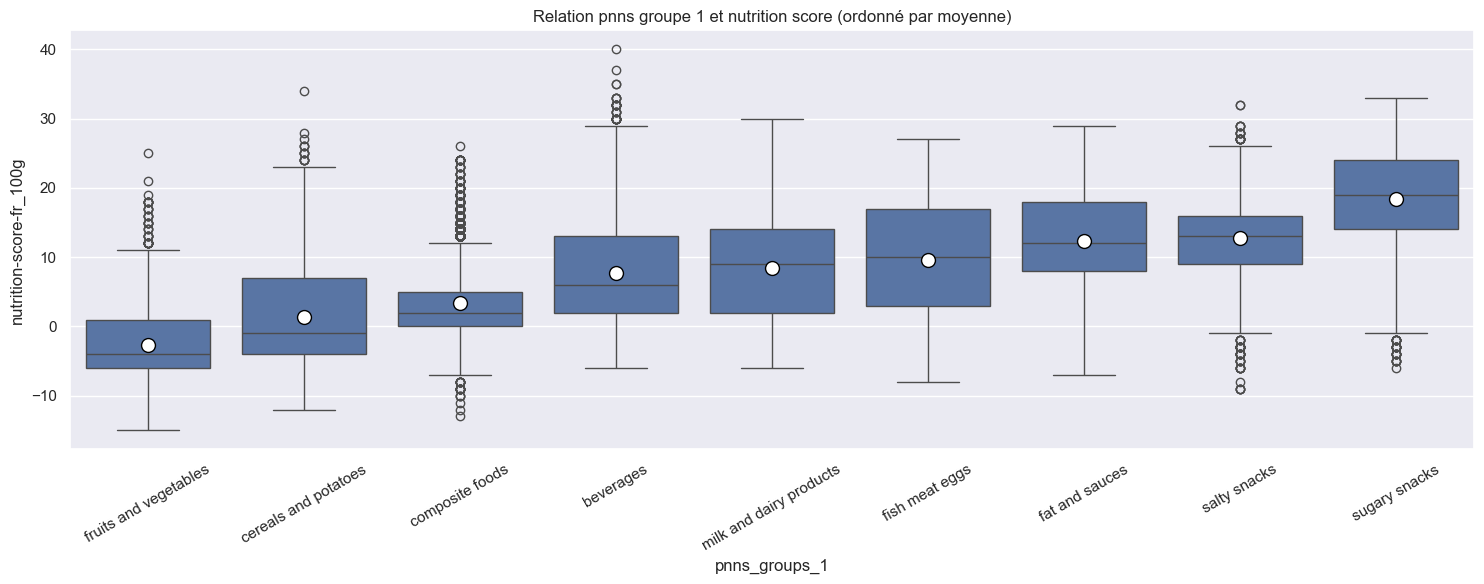

In [89]:
mean_by_group = df.groupby('pnns_groups_1')['nutrition-score-fr_100g'].mean().sort_values()

# Création de la figure avec un seul sous-graphique
plt.figure(figsize=(15, 6))

# Boîte à moustaches avec la moyenne, en ordre
sns.boxplot(x='pnns_groups_1', y='nutrition-score-fr_100g', data=df, order=mean_by_group.index,
            showmeans=True, meanprops={"marker": "o",
                                       "markerfacecolor": "white",
                                       "markeredgecolor": "black",
                                       "markersize": "10"})
plt.xticks(rotation=30)
plt.title('Relation pnns groupe 1 et nutrition score (ordonné par moyenne)')

plt.show()

On constate que pour la modalité "sugary_snacks" nous avons une médiane supérieur de nutrition-score-fr_100g supérieur au troisième quartile de toutes les autres modalités. 
La modalité de la varibale pnns_groups_1 semble affecter la distributuion de la variable nutrition-score-fr_100g.

### Relation entre données quantitatives nutritionnelles et nutriscore

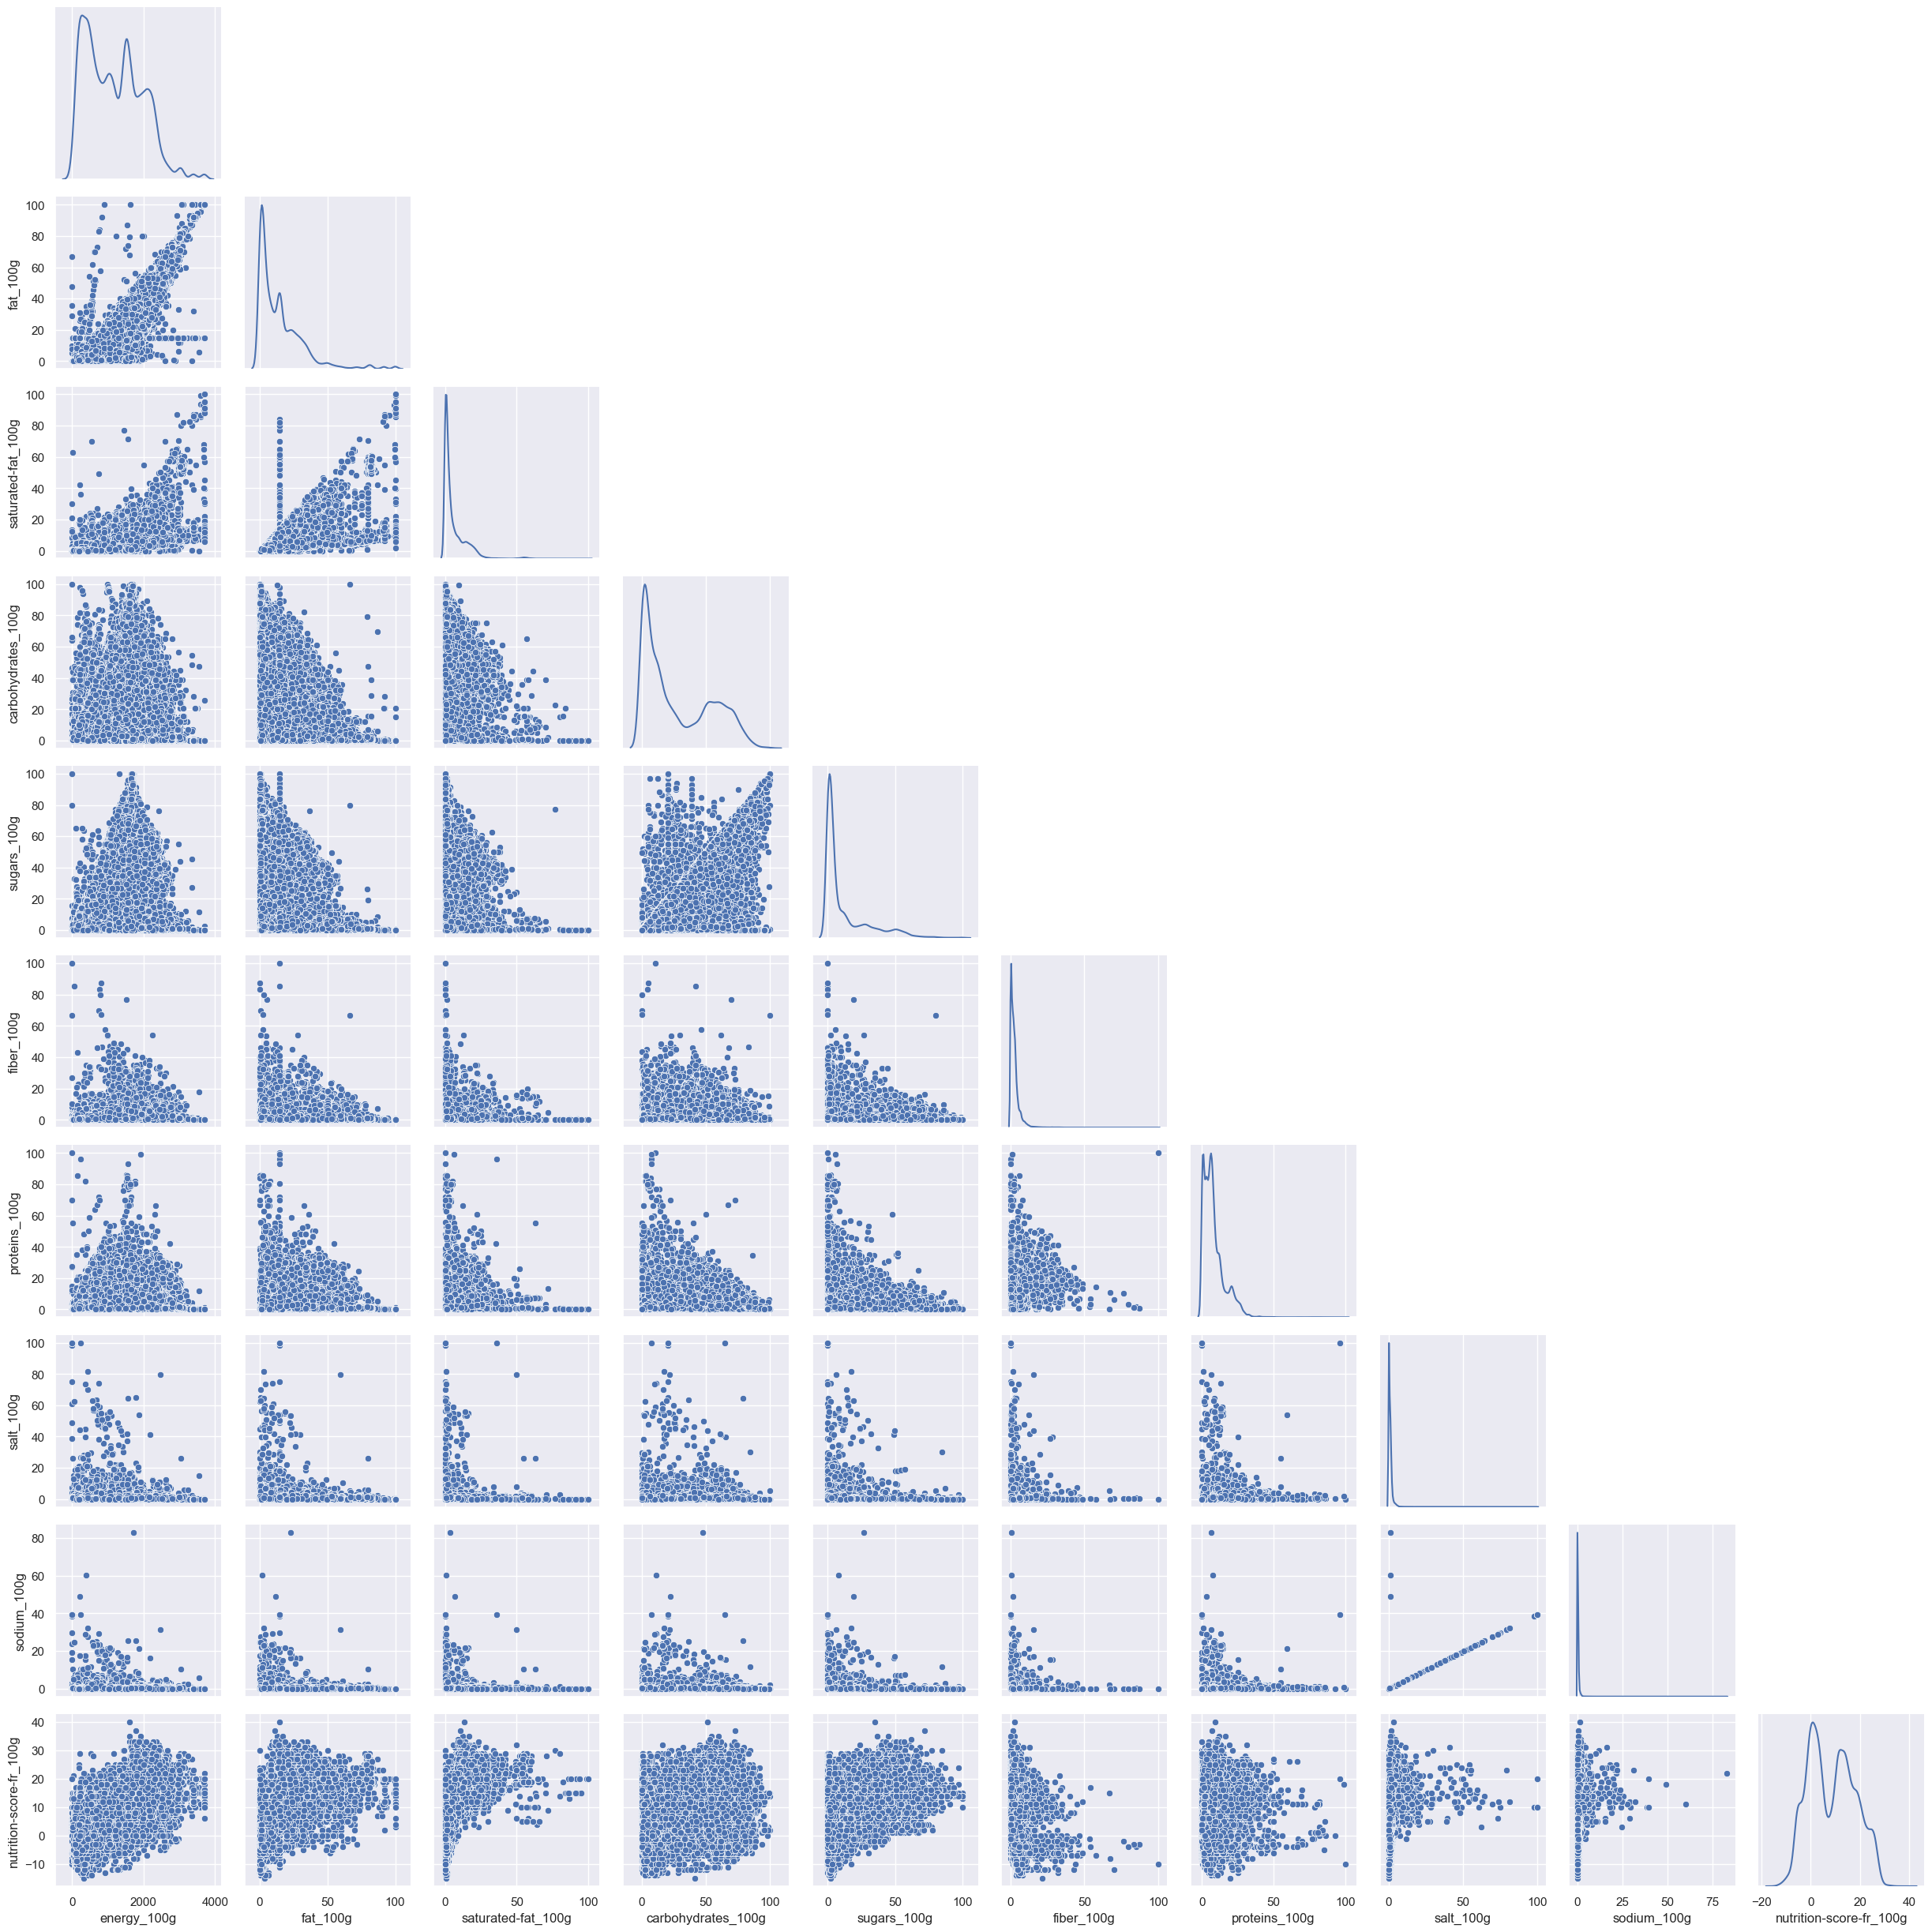

In [90]:
j=df_imput.filter(regex='_100g$',axis=1).columns.tolist()
temp=df_imput.loc[:,j]

# Création d'une grille de paires (PairGrid)
g = sns.PairGrid(temp, diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)

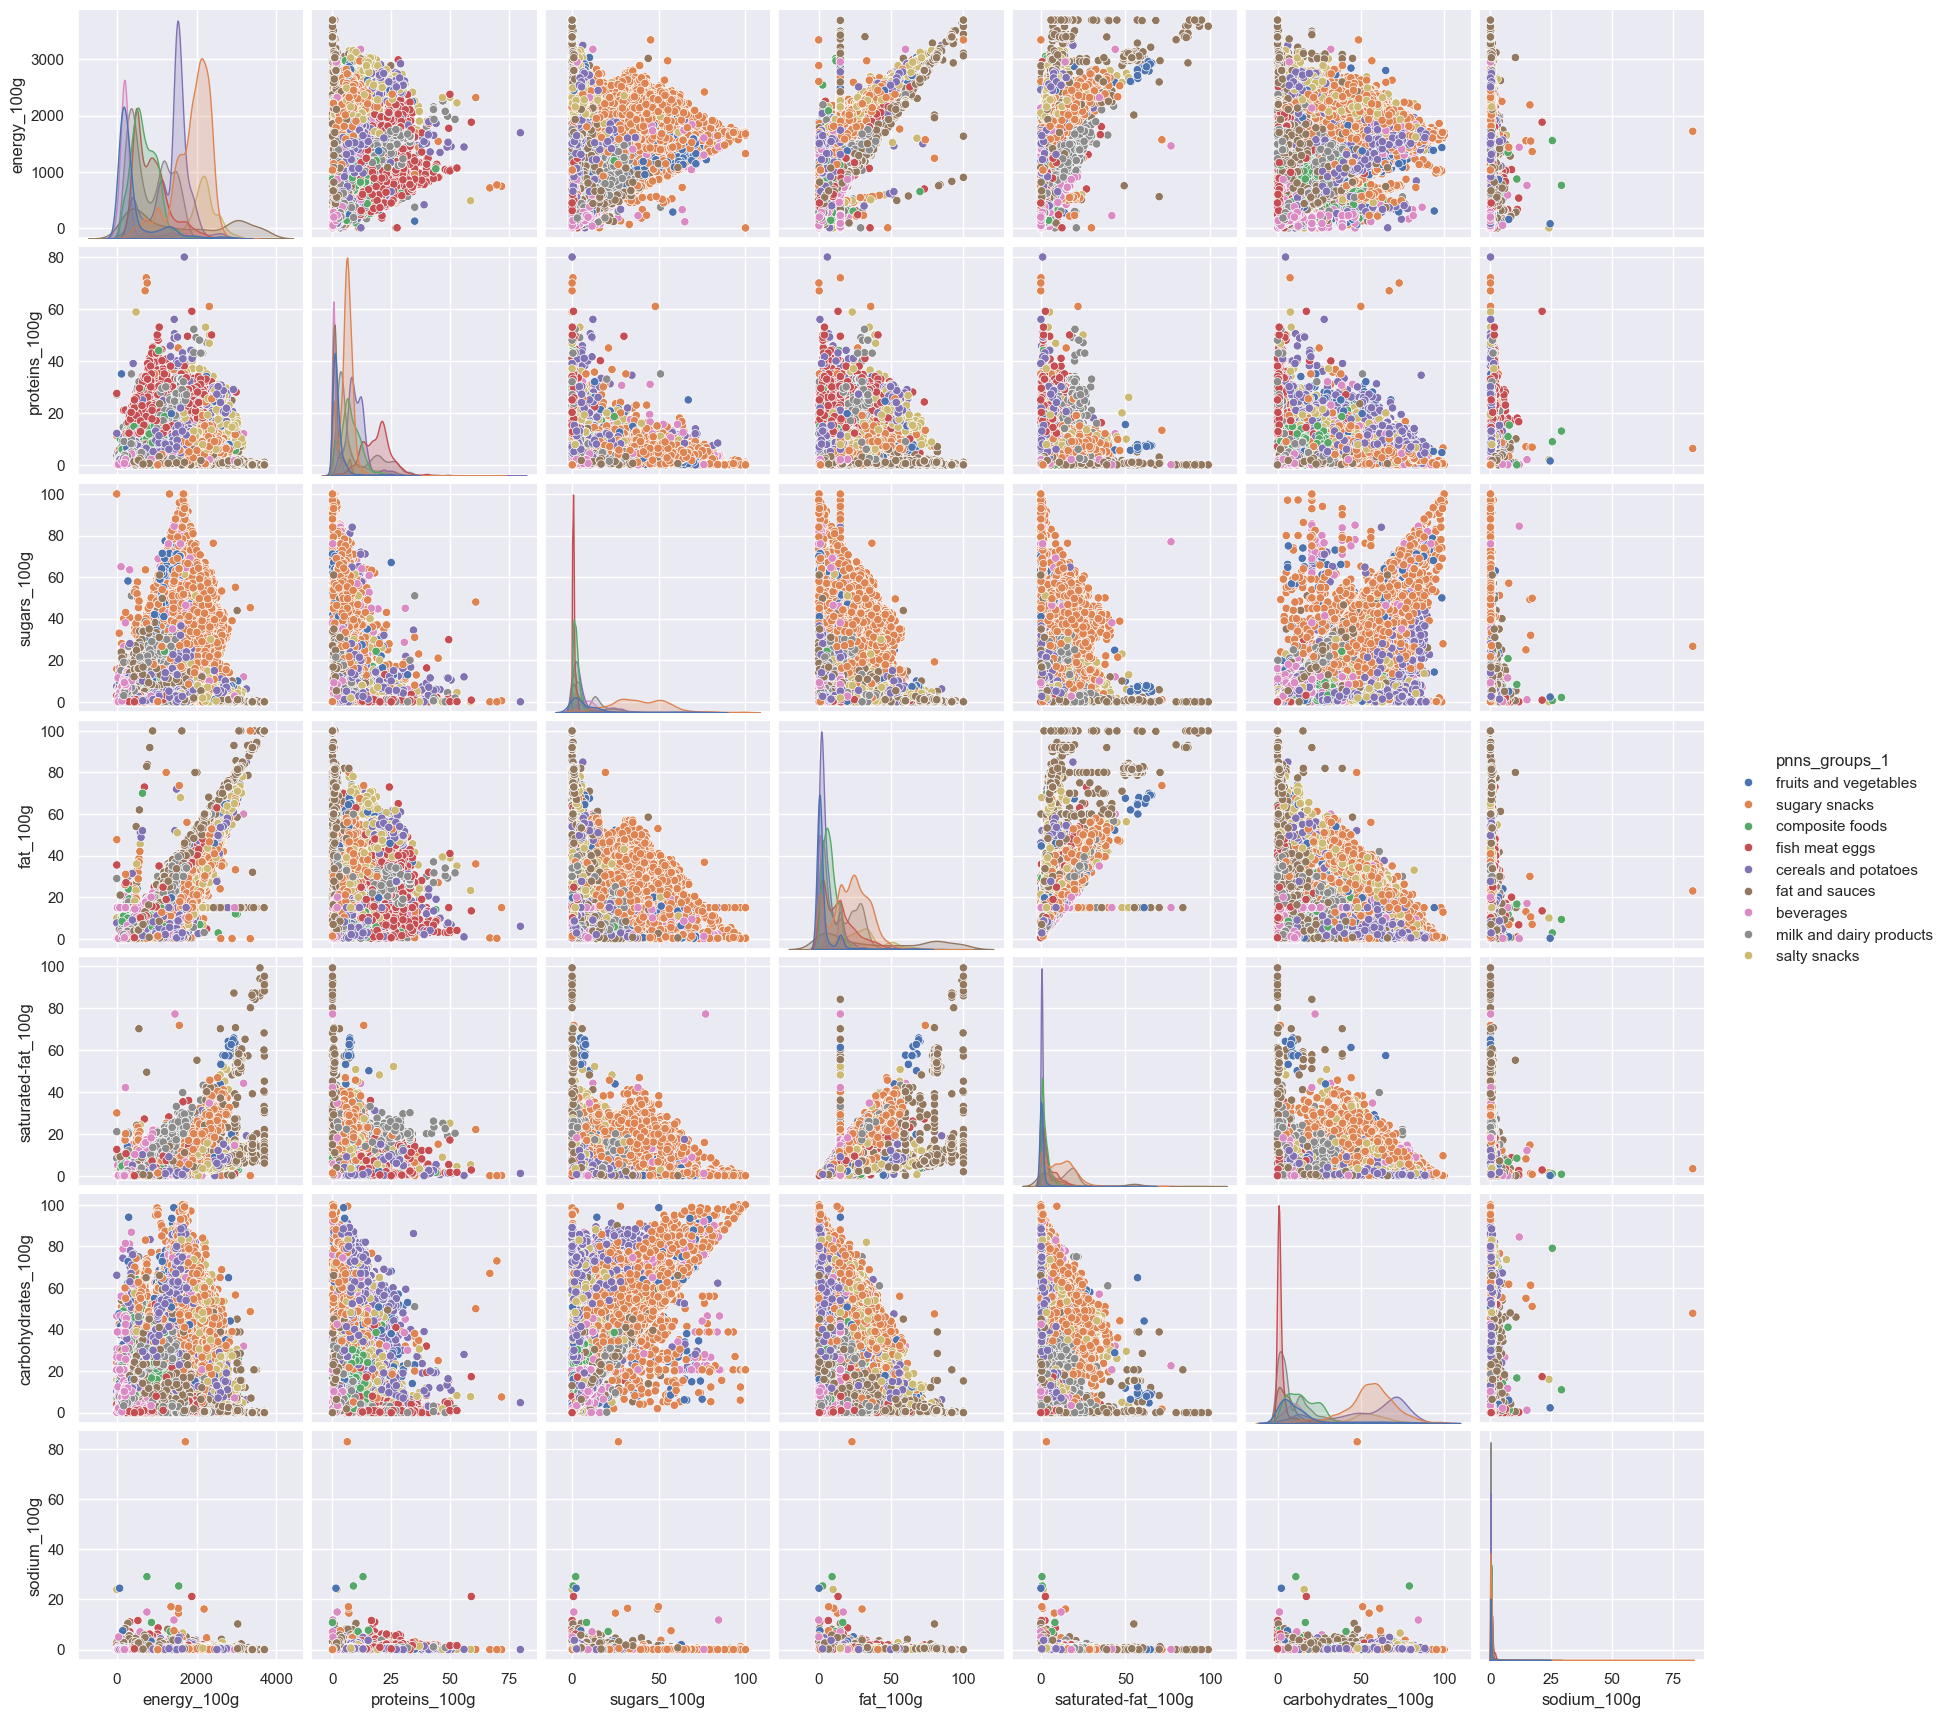

In [91]:
plot_cols =  ["energy_100g", "proteins_100g", "sugars_100g", "fat_100g", "saturated-fat_100g", "carbohydrates_100g", "sodium_100g","pnns_groups_1"]
# Copie du DataFrame initial
df = df_imput.copy() 

# Remplacement de 'unknown' par np.nan dans la colonne 'pnns_groups_1'
df['pnns_groups_1']=df['pnns_groups_1'].replace('unknown',np.nan)

# Suppression des lignes avec des valeurs manquantes dans 'pnns_groups_1'
df=df.loc[df.pnns_groups_1.notnull()]

# Sélection des colonnes à utiliser dans la pairplot
quant_data = df.loc[:,plot_cols]
# Pairplot en fonction de la variable 'pnns_groups_1'
sns.pairplot(data=quant_data, hue='pnns_groups_1')
plt.show()

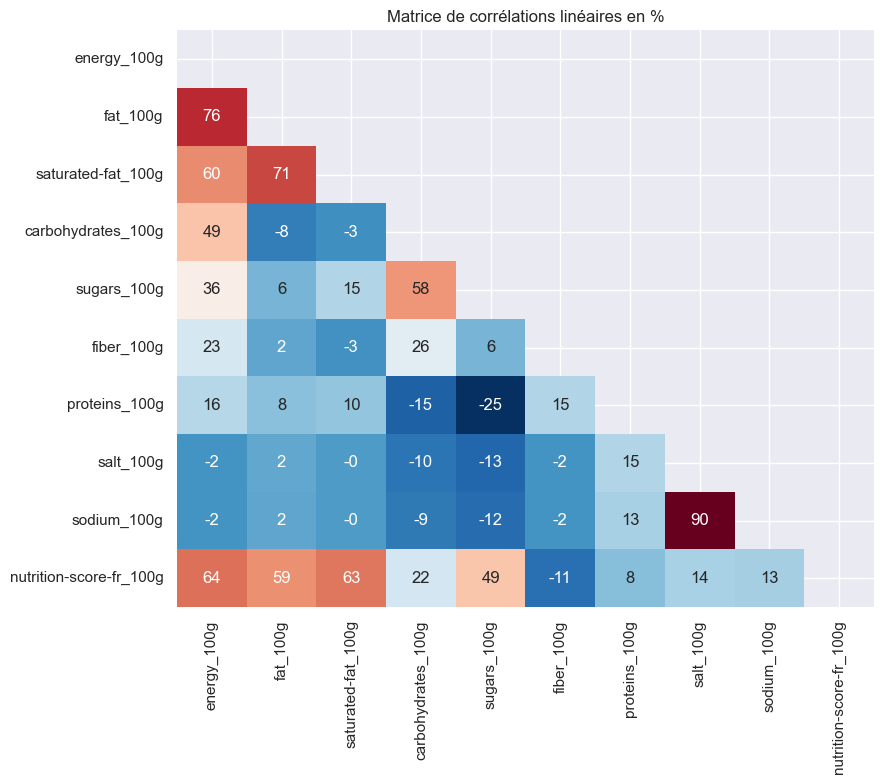

In [92]:

# Calcul des corrélations de Pearson entre les variables numériques
pearson_correlations = df_imput.filter(regex='_100g$',axis=1).select_dtypes(include='float64').corr() * 100

# Création d'un masque pour ne montrer que la moitié supérieure de la matrice de corrélations
cleanning_mask = np.zeros_like(pearson_correlations)
upper_triangle = np.triu_indices_from(pearson_correlations)
cleanning_mask[upper_triangle] = 1

# Heatmap de la matrice de corrélations
plt.figure(figsize=(9,8))
sns.heatmap(pearson_correlations, cmap="RdBu_r", mask = cleanning_mask, 
           annot = True, fmt=".0f", cbar=False)
plt.title("Matrice de corrélations linéaires en %")
plt.show()

Nous constatons des corrélations linéaires positives fortes entre les variables salt_100g et sodium_100g, fat_100g et energy_100g (78%) ainsi que entre fat_100g et saturated-fat_100g.

De plus, il y a une corrélation positive du nutrition-scrore-fr_100g avec plusieurs variables de nutriements: energy_100g (64%), fat_100g (59%) et saturated_fat_100g (63%)

In [93]:
def corr_test(var1, var2, method='pearson'):
    print("-" * 50)

    print(f"Test statistique de corrélation {method.capitalize()} entre {var1.name} et {var2.name}\n")
    
    # Calcul du coefficient de corrélation et de la p-valeur
    if method == 'pearson':
        stat, p = st.pearsonr(var1, var2)
    else:
        stat, p = st.spearmanr(var1, var2)

    # Affichage des résultats
    print(f"Coeficient de corrélation {method.capitalize()}: {stat}\n p valeur: {p}\n")

    # Interprétation des résultats en fonction du seuil de 0.05
    if p < 0.05:
        print("L'hypothèse H0 d'indépendance peut être rejetée avec un risque de 5%\n")
    else:
        print("L'hypothèse H0 d'indépendance ne peut être rejetée avec un risque de 5%\n")


corr_test(df_imput["fat_100g"],df_imput["energy_100g"])
corr_test(df_imput["fat_100g"],df_imput["saturated-fat_100g"])
corr_test(df_imput["nutrition-score-fr_100g"],df_imput["saturated-fat_100g"])
corr_test(df_imput["nutrition-score-fr_100g"],df_imput["energy_100g"])
corr_test(df_imput["nutrition-score-fr_100g"],df_imput["fat_100g"])
corr_test(df_imput["nutrition-score-fr_100g"],df_imput["sugars_100g"])


--------------------------------------------------
Test statistique de corrélation Pearson entre fat_100g et energy_100g

Coeficient de corrélation Pearson: 0.7613787933549457
 p valeur: 0.0

L'hypothèse H0 d'indépendance peut être rejetée avec un risque de 5%

--------------------------------------------------
Test statistique de corrélation Pearson entre fat_100g et saturated-fat_100g

Coeficient de corrélation Pearson: 0.710349721752999
 p valeur: 0.0

L'hypothèse H0 d'indépendance peut être rejetée avec un risque de 5%

--------------------------------------------------
Test statistique de corrélation Pearson entre nutrition-score-fr_100g et saturated-fat_100g

Coeficient de corrélation Pearson: 0.6349921964067639
 p valeur: 0.0

L'hypothèse H0 d'indépendance peut être rejetée avec un risque de 5%

--------------------------------------------------
Test statistique de corrélation Pearson entre nutrition-score-fr_100g et energy_100g

Coeficient de corrélation Pearson: 0.643298406749

# 2. c) Analyse multivariée

### Analyse explicative entre la variable catégorielle et variable quantitatif : GROUPE 1 et NUTRISCORE : ANOVA

sum_sq        df        F  PR(>F)
C(group1) 21,813.36      8.00 5,286.93    0.00
Residual  23,222.64 45,028.00      NaN     NaN

Plot des residus


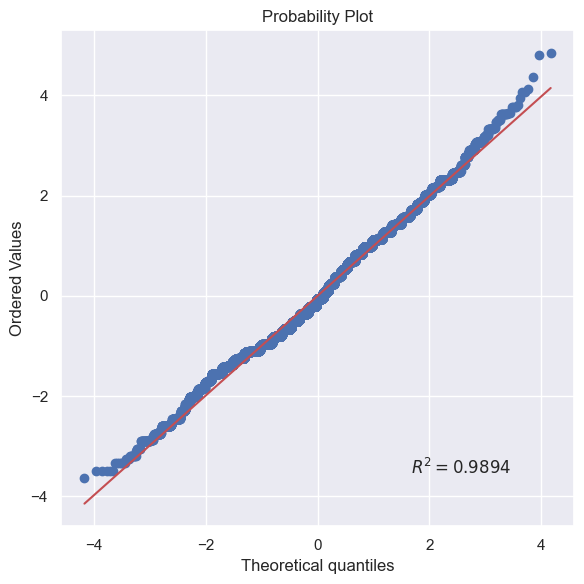

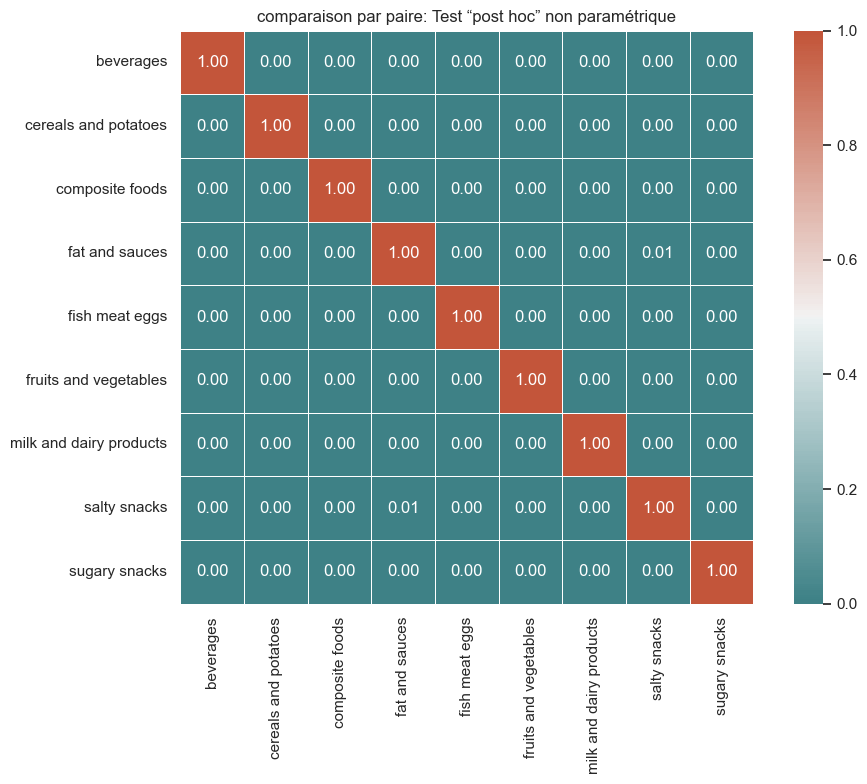

In [94]:
# Extraction des colonnes pertinentes 
df_anova=df_imput.loc[:,['nutrition-score-fr_100g','pnns_groups_1']].copy()

# Remplacement de 'unknown' par np.nan dans la colonne 'pnns_groups_1'
df_anova['pnns_groups_1']=df_anova['pnns_groups_1'].replace('unknown',np.nan)

# Suppression des lignes avec des valeurs manquantes dans 'pnns_groups_1'
df_anova=df_anova.loc[df_anova.pnns_groups_1.notnull()]

# Normalisation des scores
df_anova.columns=['score','group1']
df_anova['score_norm']=(df_anova['score']-df_anova['score'].median())/df_anova['score'].std()

# Modèle ANOVA (Analyse de variance)
model = ols('score_norm ~ C(group1)', data=df_anova).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

display(anova_table)

# Plot des résidus
print('Plot des residus')
plt.rcParams["figure.figsize"] = [6, 6]
plt.rcParams["figure.autolayout"] = True
sns.set_theme(color_codes=True)

# QQ-plot des résidus pour vérifier la normalité
stats.probplot((model.resid-model.resid.mean())/model.resid.std(), dist='norm',plot= plt, rvalue= True)
plt.show()

# Test de Kruskal-Wallis
kstat, pval = stats.kruskal(*[group['score_norm'].values for name, group in df_anova.loc[:,['score_norm','group1']].groupby('group1')])

# Heatmap pour le test post-hoc
plt.rcParams["figure.figsize"] = [10, 8]
sns.heatmap(
    sp.posthoc_conover(df_anova, val_col='score_norm', group_col='group1', p_adjust = 'holm'), 
    vmin=0, vmax=1, center=0.5,
    cmap=sns.diverging_palette(200, 20, n=200),
    square=True,
    annot=True,
    fmt='.2f',
    linewidths=.5)
plt.title('comparaison par paire: Test “post hoc” non paramétrique')
plt.show()

#### 1. Kurtosis et Skewness :
Kurtosis : Mesure l'aplatissement ou l'étalement de la distribution des données. Un kurtosis négatif (platykurtique) indique que les données ont des queues moins lourdes et sont moins étalées que la distribution normale.
Skewness : Mesure l'asymétrie de la distribution des données. Une skewness positive indique que la distribution a une queue plus longue du côté droit (asymétrie positive), tandis qu'une skewness négative indique une queue plus longue du côté gauche (asymétrie négative).
Ici une kurtosis de -0.39 indique une légère platykurtose, et une skewness de 0.20 indique une légère asymétrie positive legerement décalée à droite.

#### 2. Test de normalité d'Agostino/Omnibus :
Le test d'Agostino/Omnibus évalue si un échantillon provient d'une distribution normale. La p-value associée au test est comparée à un seuil de signification (0.05 généralement). Si la p-value est inférieure à ce seuil, l'hypothèse nulle (H0 : les données suivent une distribution normale) est rejetée. D'après les résultats, la p-value est de 0.00, ce qui suggère que les résidus ne suivent pas une distribution normale.

#### 3. ANOVA non paramétrique - Test de Kruskal-Wallis :
Lorsque les résidus ne suivent pas une distribution normale, une alternative à l'ANOVA paramétrique est l'ANOVA non paramétrique, telle que le test de Kruskal-Wallis. Ce test évalue si les moyennes des groupes sont égales ou différentes, mais sans faire l'hypothèse que les données suivent une distribution normale. La p-value associée au test de Kruskal-Wallis est évaluée de manière similaire à celle du test d'Agostino/Omnibus.

#### 4. Post Hoc :
Après avoir rejeté l'hypothèse nulle avec le test de Kruskal-Wallis, une analyse post hoc est généralement effectuée pour identifier quelles modalités présentent des différences significatives entre elles. Les tests post hoc comparent toutes les paires de groupes et fournissent des p-values ajustées pour tenir compte du risque d'erreur de type I accru lié à la réalisation de multiples comparaisons.

En conclusion, les résultats suggèrent que les résidus ne suivent pas une distribution normale, justifiant l'utilisation d'une ANOVA non paramétrique (Kruskal-Wallis). Les résultats du test indiquent des différences significatives entre les modalités, et l'analyse post hoc confirme des différences significatives entre toutes les paires de groupes. Cela peut indiquer des variations significatives dans les données, même si elles ne suivent pas une distribution normale.

### ACP

Nous réalisons l'analyse multivarié grâce à une ACP sur les variables quantitatives. Voici les variables utilisées :

- energy_100g
- fat_100g
- saturated-fat_100g
- carbohydrates_100g
- sugars_100g
- fiber_100g
- proteins_100g
- salt_100g
- sodium_100g

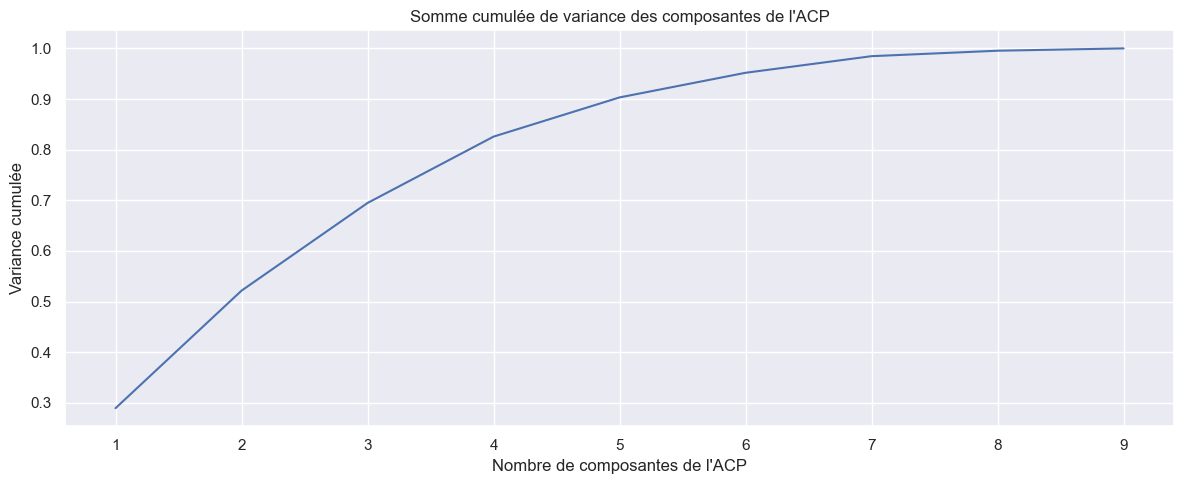

In [95]:
columns = ['energy_100g', 'fat_100g','saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
           'proteins_100g', 'salt_100g', 'sodium_100g']

# Extraction des colonnes pertinentes 
df_acp = df_imput[columns]

# Liste des colonnes à utiliser pour l'ACP
colonnes_acp = df_acp.columns

# Standardisation des données : ramener les données à une moyenne nulle et une variance de 1
scaler = StandardScaler()
data_acp = scaler.fit_transform(df_acp)

# Création d'une instance de l'objet PCA avec le nombre de composantes égal au nombre de colonnes
acp = PCA(n_components = data_acp.shape[1])

# Ajustement de l'ACP aux données standardisées
acp.fit(data_acp)

# Affichage des ratios de variance expliquée par chaque composante
acp.explained_variance_ratio_
plt.figure(figsize=(12,5))
plt.title('Somme cumulée de variance des composantes de l\'ACP')
plt.xlabel('Nombre de composantes de l\'ACP')
plt.ylabel('Variance cumulée')
plt.plot(np.linspace(1,9,9),
         np.cumsum(acp.explained_variance_ratio_))

Il apparaît qu'il est nécessaire d'avoir recours à 4 composantes principales, pour huit variables, afin de capter au moins 80% de l'inertie. Le phénomène explique d'une part des diagrammes difficilement exploitables voir pas interprétables et d'autre part un faible intérêt dans une recherche de réduction de dimensions.

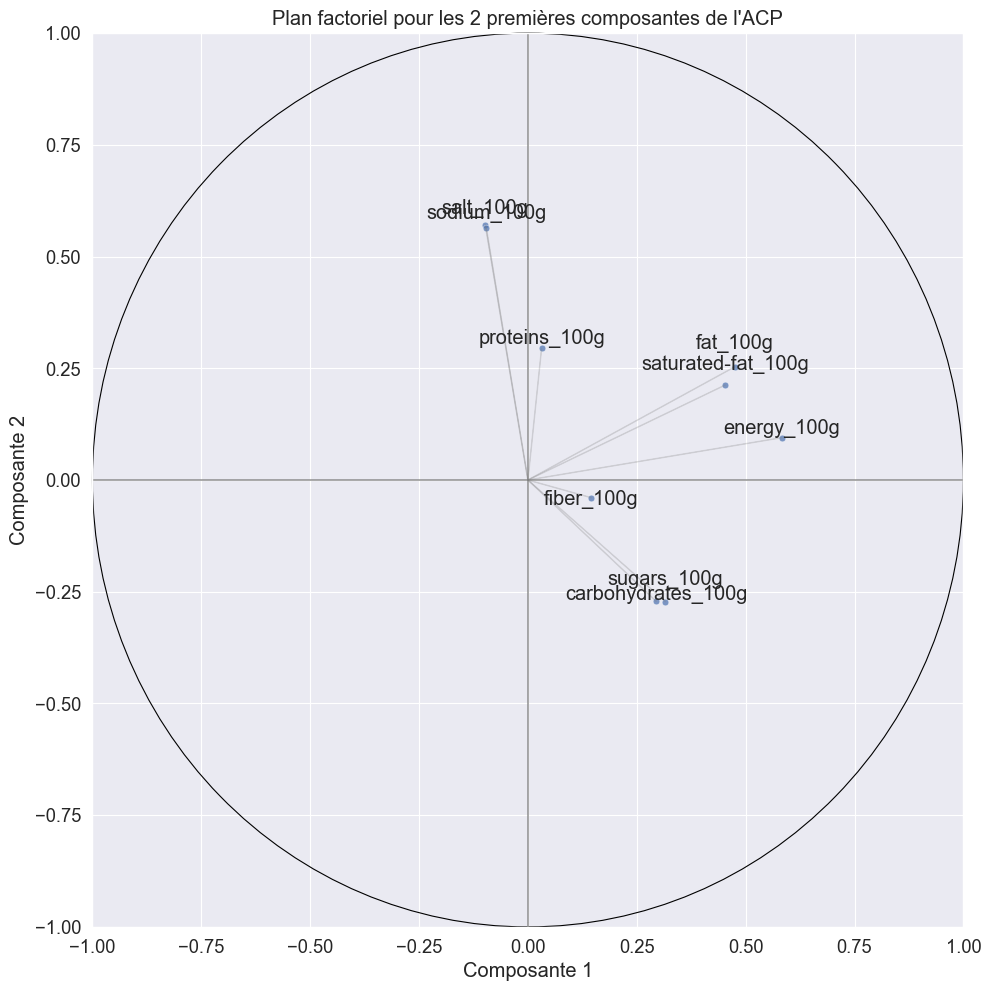

In [96]:
sns.set_context("paper", font_scale=1.5) 
plt.figure(figsize=(10,10))
chaine = "Plan factoriel pour les 2 premières composantes de l'ACP"
plt.title(chaine)

# Noms des axes
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')

# Ajout d'un cercle de rayon 1 centré à l'origine (0,0)
ax = plt.gca()
ax.add_patch(Circle([0,0], radius=1, color='black', fill=False, linestyle='-', clip_on=False))
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

# Coordonnées des composantes principales
x_acp = acp.components_[0,:]
y_acp = acp.components_[1,:]

# Nuage de points représentant les composantes
sns.scatterplot(x = x_acp,
                y = y_acp,
               alpha = 0.7)
plt.plot([-1,1],[0,0], color='grey', alpha=0.8)
plt.plot([0,0],[-1,1], color='grey', alpha=0.8)

i = 0
for x,y,colonne in zip(x_acp,y_acp, colonnes_acp):

    plt.annotate(colonne, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,5+np.random.randint(-10,10)),
                 ha='center') 
    ax.arrow(0, 0, x, y, head_width=0, head_length=0, fc='grey', ec='grey',alpha=0.2)


sns.set_context("paper", font_scale=1) 

L'interprétation du cercle de corrélation n'est pas équivoque. Le fait est dû au faible nombre de variables en entrée ainsi qu'une qualité de projection moyenne.

Nous pouvons tout de même observer que la première composante principale est définiee par le niveau de calories et de graisse des observations. La définition de la seconde est moins évidente. Elle oppose les produits riches en protéines aux produits riches en sucres et glucides.

- correlation positive entre gras et energie
- correlation positive entre proteine et sel
- correlation positive entre sucre et hydrates de carbone
- correlation négative entre sucre et sel
- correlation parfait entre sel et sodium

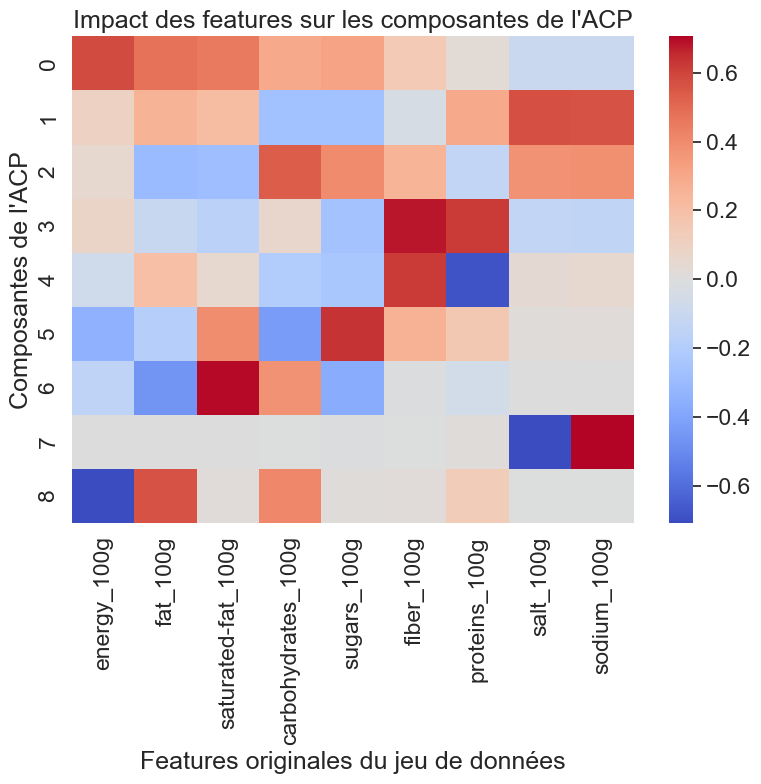

In [97]:
# Créé pour stocker les composantes de l'ACP.
acp_analysis = pd.DataFrame(acp.components_)
acp_analysis.columns = colonnes_acp

sns.set(font_scale=1.5)
plt.figure(figsize=(8,8))
sns.set
sns.heatmap(acp_analysis, cmap='coolwarm')
plt.title('Impact des features sur les composantes de l\'ACP')
plt.xlabel('Features originales du jeu de données')
plt.ylabel('Composantes de l\'ACP')
sns.set(font_scale=1)

Chaque ligne représente une composante principale et chaque colonne correspond à une variable originale du jeu de données.

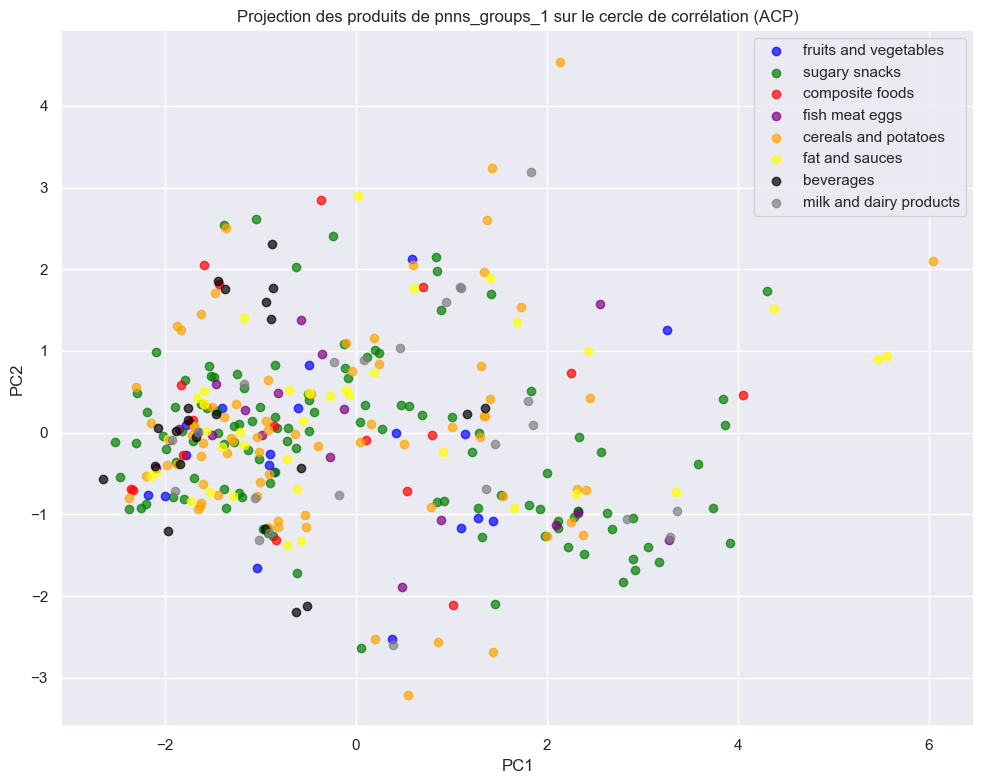

In [98]:
numeric_columns = ['energy_100g', 'fat_100g', 'saturated-fat_100g',
                   'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
                   'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g']

df_numeric = df[numeric_columns]

# Remplacez les valeurs non numériques par des NaN et supprimez les lignes avec des NaN
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce').dropna()

# Standardisez les données
scaler = StandardScaler()
df_numeric_scaled = scaler.fit_transform(df_numeric)

# Appliquez l'ACP
pca = PCA(n_components=2)  # Réduire le nombre de composantes à 2
df_pca = pca.fit_transform(df_numeric_scaled)

# Créez un DataFrame pour les composantes principales
df_pca_result = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])

# Ajoutez la colonne 'pnns_groups_1' au DataFrame résultant
df_pca_result['pnns_groups_1'] = df['pnns_groups_1']
df_pca_result['pnns_groups_1']=df_pca_result['pnns_groups_1'].replace('unknown',np.nan)
df_pca_result=df_pca_result.loc[df_pca_result.pnns_groups_1.notnull()]

# Affichez le cercle de corrélation
fig, ax = plt.subplots(figsize=(10, 8))
for category, color in zip(df_pca_result['pnns_groups_1'].unique(), ['blue', 'green', 'red', 'purple', 'orange','yellow','black','gray']):
    subset = df_pca_result[df_pca_result['pnns_groups_1'] == category]
    ax.scatter(subset['PC1'], subset['PC2'], c=color, label=category, alpha=0.7)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Projection des produits de pnns_groups_1 sur le cercle de corrélation (ACP)')
ax.legend()
plt.show()

Le graphique ne montre pas de tendance claire, cela pourrait indiquer que les variables initiales ne sont pas fortement corrélées avec les composantes principales ou qu'il n'y a pas de structure claire dans les données en termes de variance par rapport aux composantes principales. 